In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\10120
10120


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.406479238383
Gradient descend method:  None
RUN  0 , total integrated cost =  5902.406479238383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  0 , total integrated cost =  5538.707762167343
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  0 , total integrated cost =  13602.2666253313
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set 

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  1 , total integrated cost =  33.60637486789846
RUN  2 , total integrated cost =  30.16577083230619
RUN  3 , total integrated cost =  24.98015204018204
RUN  4 , total integrated cost =  22.84244731952398
RUN  5 , total integrated cost =  19.461998798945988
RUN  6 , total integrated cost =  18.231169245822343
RUN  7 , total integrated cost =  16.60422876248539
RUN  8 , total integrated cost =  15.596119618731098
RUN  9 , total integrated cost =  14.06771163910822
RUN  10 , total integrated cost =  13.347347097615133
RUN  11 , total integrated cost =  12.49590230010771
RUN  12 , total integrated cost =  11.080349570710931
RUN  13 , total integrated cost =  10.091416789612959
RUN  14 , total integrated cost =  10.037768030710962
RUN  15 , 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  49 , total integrated cost =  7.909241486786011
Improved over  49  iterations in  26.9306197  seconds by  99.85720059937427  percent.
Problem in initial value trasfer:  Vmean_exc -66.17132198175533 -66.16766974746442
weight =  7002.8305134201255
set cost params:  1.0 0.0 7002.8305134201255
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5499.800455643624
Gradient descend method:  None
RUN  1 , total integrated cost =  5260.0114352446235
RUN  2 , total integrated cost =  5258.777884043792
RUN  3 , total integrated cost =  5258.769137060292
RUN  4 , total integrated cost =  5258.768579982372
RUN  5 , total integrated cost =  5258.768536347584
RUN  6 , total integrated cost =  5258.768534256966
RUN  7 , total integrated cost =  5258.768534187663
RUN  8 , total integrated cost =  5258.768534187658
RUN  9 , total integrated cost =  5258.768534187653


ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  5258.768534187653
Control only changes marginally.
RUN  10 , total integrated cost =  5258.768534187653
Improved over  10  iterations in  2.1736463000000015  seconds by  4.382557574586841  percent.
Problem in initial value trasfer:  Vmean_exc -62.975402679686084 -63.01635664025125
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  1 , total integrated cost =  101.76003413797613
RUN  2 , total integrated cost =  86.51375099376757
RUN  3 , total integrated cost =  69.12795076359853
RUN  4 , total integrated cost =  62.40286249302984
RUN  5 , total integrated cost =  55.291967895886195
RUN  6 , total integrated cost =  51.04818082069224
RUN  7 , total integrated cost =  46.9081419495247
RUN  8 , total integrated cost =  43.631386650266656
RUN  9 , total integrated cost =  40.85563171635377
RUN  10 , tot

ERROR:root:Problem in initial value trasfer


RUN  70 , total integrated cost =  27.75557205725876
Control only changes marginally.
RUN  70 , total integrated cost =  27.75557205725876
Improved over  70  iterations in  11.369381900000008  seconds by  99.79594891923696  percent.
Problem in initial value trasfer:  Vmean_exc -62.38274548421541 -62.38478198471827
weight =  4900.733660711553
set cost params:  1.0 0.0 4900.733660711553
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13262.004265096019
Gradient descend method:  None
RUN  1 , total integrated cost =  12368.442911189144
RUN  2 , total integrated cost =  12356.697650668213
RUN  3 , total integrated cost =  12349.038100075451
RUN  4 , total integrated cost =  12326.645168084613
RUN  5 , total integrated cost =  12308.521955632925
RUN  6 , total integrated cost =  12192.963414339136
RUN  7 , total integrated cost =  12191.82405632705
RUN  8 , total integrated cost =  12191.820786347462
RUN  9 , total integrated cost =  12191.820734387544
RUN  10 , tota

ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  12191.820734387527
Control only changes marginally.
RUN  13 , total integrated cost =  12191.820734387527
Improved over  13  iterations in  3.2764746999999943  seconds by  8.069545969948777  percent.
Problem in initial value trasfer:  Vmean_exc -57.534017750397425 -57.52694581733711
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9439.076736893423
Gradient descend method:  None
RUN  1 , total integrated cost =  69.5467012836641
RUN  2 , total integrated cost =  58.545691766221466
RUN  3 , total integrated cost =  45.19081171150406
RUN  4 , total integrated cost =  39.775556494920096
RUN  5 , total integrated cost =  35.39518789531382
RUN  6 , total integrated cost =  32.865475673793334
RUN  7 , total integrated cost =  30.814021062360503
RUN  8 , total integrated cost =  29.201601031020846
RUN  9 , total integrated cost =  27.959575822570464
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  72 , total integrated cost =  17.06602967317013
Improved over  72  iterations in  15.077158999999995  seconds by  99.8191981043393  percent.
Problem in initial value trasfer:  Vmean_exc -66.06644974513998 -66.06845766487994
weight =  5530.915460514402
set cost params:  1.0 0.0 5530.915460514402
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9330.726778484419
Gradient descend method:  None
RUN  1 , total integrated cost =  8839.349652979701
RUN  2 , total integrated cost =  8836.715492840063
RUN  3 , total integrated cost =  8836.016407511768
RUN  4 , total integrated cost =  8835.99936051999
RUN  5 , total integrated cost =  8835.992405291863
RUN  6 , total integrated cost =  8835.986181207116
RUN  7 , total integrated cost =  8835.974000551018
RUN  8 , total integrated cost =  8835.84165012679
RUN  9 , total integrated cost =  8833.0374089056
RUN  10 , total integrated cost =  8832.184813813563
RUN  11 , total integrated c

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  8815.659080871537
Control only changes marginally.
RUN  30 , total integrated cost =  8815.659080871537
Improved over  30  iterations in  7.646743700000002  seconds by  5.520124100092275  percent.
Problem in initial value trasfer:  Vmean_exc -60.62080275564536 -60.64865327052391
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17551.147823015366
Gradient descend method:  None
RUN  1 , total integrated cost =  126.04961426559234
RUN  2 , total integrated cost =  107.33059740783882
RUN  3 , total integrated cost =  83.2431645973395
RUN  4 , total integrated cost =  74.51736899359668
RUN  5 , total integrated cost =  65.52982212580403
RUN  6 , total integrated cost =  60.60019236399125
RUN  7 , total integrated cost =  55.907283289728895
RUN  8 , total integrated cost =  51.75180736066079
RUN  9 , total integrated cost =  48.520585997332105
RUN  10 , 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  77 , total integrated cost =  34.78911505816674
Improved over  77  iterations in  15.381079100000008  seconds by  99.80178438806978  percent.
Problem in initial value trasfer:  Vmean_exc -61.955454537091114 -61.958104047818466
weight =  5045.011289787101
set cost params:  1.0 0.0 5045.011289787101
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17226.53864273826
Gradient descend method:  None
RUN  1 , total integrated cost =  15995.09082567015
RUN  2 , total integrated cost =  15784.902936657341
RUN  3 , total integrated cost =  15708.701239981228
RUN  4 , total integrated cost =  15707.40549616588
RUN  5 , total integrated cost =  15700.36533587835
RUN  6 , total integrated cost =  15696.041283473214
RUN  7 , total integrated cost =  15694.81950619864
RUN  8 , total integrated cost =  15691.602488743965
RUN  9 , total integrated cost =  15690.638956859839
RUN  10 , total integrated cost =  15688.278973749602
RUN  11 , total

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  43 , total integrated cost =  15660.832748808712
Improved over  43  iterations in  9.685178099999987  seconds by  9.088917549838484  percent.
Problem in initial value trasfer:  Vmean_exc -57.059390169668674 -57.047906367631924
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  125.26289955820035
RUN  2 , total integrated cost =  105.92492925169437
RUN  3 , total integrated cost =  80.22470706687312
RUN  4 , total integrated cost =  71.44511409076074
RUN  5 , total integrated cost =  62.46780298801317
RUN  6 , total integrated cost =  57.60483108197231
RUN  7 , total integrated cost =  53.195504903765496
RUN  8 , total integrated cost =  48.90792142940432
RUN  9 , total integrated cost =  45.90258293696501
RUN  10 ,

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  52 , total integrated cost =  34.03151007592799
Improved over  52  iterations in  10.806743600000004  seconds by  99.8063222218525  percent.
Problem in initial value trasfer:  Vmean_exc -64.04353007909012 -64.04738185209422
weight =  5163.21495199307
set cost params:  1.0 0.0 5163.21495199307
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17241.013457143607
Gradient descend method:  None
RUN  1 , total integrated cost =  15871.851171809143
RUN  2 , total integrated cost =  15868.273490456239
RUN  3 , total integrated cost =  15804.708559568304
RUN  4 , total integrated cost =  15778.431981902793
RUN  5 , total integrated cost =  15778.253938975125
RUN  6 , total integrated cost =  15778.053448976238
RUN  7 , total integrated cost =  15776.551021401612
RUN  8 , total integrated cost =  15776.14719707926
RUN  9 , total integrated cost =  15776.07899521384
RUN  10 , total integrated cost =  15767.3349264031
RUN  11 , total int

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  15763.131989359614
Control only changes marginally.
RUN  30 , total integrated cost =  15763.131989359614
Improved over  30  iterations in  6.871288600000014  seconds by  8.571894404337641  percent.
Problem in initial value trasfer:  Vmean_exc -57.49822411563244 -57.48791014145417
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8796.175560697715
Gradient descend method:  None
RUN  1 , total integrated cost =  62.84008034993996
RUN  2 , total integrated cost =  55.181279177975966
RUN  3 , total integrated cost =  43.09786337698986
RUN  4 , total integrated cost =  38.92339935491909
RUN  5 , total integrated cost =  34.24995385831945
RUN  6 , total integrated cost =  31.68572871742354
RUN  7 , total integrated cost =  29.120541855244763
RUN  8 , total integrated cost =  27.0944961064211
RUN  9 , total integrated cost =  25.280993899124798
RUN  10 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  44 , total integrated cost =  15.207022616569766
Improved over  44  iterations in  9.710518400000012  seconds by  99.82711779100322  percent.
Problem in initial value trasfer:  Vmean_exc -68.4609718038216 -68.47600157317024
weight =  5784.285183552821
set cost params:  1.0 0.0 5784.285183552821
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8700.71912320486
Gradient descend method:  None
RUN  1 , total integrated cost =  8245.47301755064
RUN  2 , total integrated cost =  8239.605308842018
RUN  3 , total integrated cost =  8239.573641875677
RUN  4 , total integrated cost =  8239.571817605687
RUN  5 , total integrated cost =  8239.571572224242
RUN  6 , total integrated cost =  8239.571528676714
RUN  7 , total integrated cost =  8239.571522990946
RUN  8 , total integrated cost =  8239.571522593858
RUN  9 , total integrated cost =  8239.57152231054
RUN  10 , total integrated cost =  8239.571521811955
RUN  11 , total integrated 

ERROR:root:Problem in initial value trasfer


RUN  18 , total integrated cost =  8239.571519474363
Control only changes marginally.
RUN  18 , total integrated cost =  8239.571519474363
Improved over  18  iterations in  4.01422359999998  seconds by  5.300109073750178  percent.
Problem in initial value trasfer:  Vmean_exc -61.288480771329674 -61.325418751595244
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17340.897955123706
Gradient descend method:  None
RUN  1 , total integrated cost =  123.780595847549
RUN  2 , total integrated cost =  105.44591638926866
RUN  3 , total integrated cost =  79.61422420249312
RUN  4 , total integrated cost =  70.87763471481495
RUN  5 , total integrated cost =  61.644226364637476
RUN  6 , total integrated cost =  56.7935082280461
RUN  7 , total integrated cost =  52.65287847342662
RUN  8 , total integrated cost =  49.52051864195335
RUN  9 , total integrated cost =  47.157182505851665
RUN  10 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  64 , total integrated cost =  33.20466694829265
Improved over  64  iterations in  13.409219399999984  seconds by  99.80851818034901  percent.
Problem in initial value trasfer:  Vmean_exc -65.19117392336322 -65.20003126312724
weight =  5222.427914162638
set cost params:  1.0 0.0 5222.427914162638
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16992.590193888074
Gradient descend method:  None
RUN  1 , total integrated cost =  15671.566783286316
RUN  2 , total integrated cost =  15667.601869164127
RUN  3 , total integrated cost =  15662.873189968135
RUN  4 , total integrated cost =  15656.836925412223
RUN  5 , total integrated cost =  15655.910740189187
RUN  6 , total integrated cost =  15616.881765683174
RUN  7 , total integrated cost =  15606.416022175854
RUN  8 , total integrated cost =  15606.394965156245
RUN  9 , total integrated cost =  15606.394582347977
RUN  10 , total integrated cost =  15606.394576681092
RUN  11 , to

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  15606.394576474344
Control only changes marginally.
RUN  15 , total integrated cost =  15606.394576474344
Improved over  15  iterations in  3.539864699999981  seconds by  8.157647548708141  percent.
Problem in initial value trasfer:  Vmean_exc -57.76548559796632 -57.75850577002092
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.159244301901
Gradient descend method:  None
RUN  1 , total integrated cost =  10.413860755688132
RUN  2 , total integrated cost =  9.825676929069918
RUN  3 , total integrated cost =  8.244898994758161
RUN  4 , total integrated cost =  7.882023763982398
RUN  5 , total integrated cost =  7.1902111094385575
RUN  6 , total integrated cost =  6.910213555698967
RUN  7 , total integrated cost =  6.385122750704883
RUN  8 , total integrated cost =  6.138872704203626
RUN  9 , total integrated cost =  5.457374298430867
RUN  10 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  3.42725696517867
Improved over  26  iterations in  4.35856339999998  seconds by  99.90664374010748  percent.
Problem in initial value trasfer:  Vmean_exc -71.22851668742605 -71.25099676623509
weight =  10711.654485208743
set cost params:  1.0 0.0 10711.654485208743
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3621.1641020099146
Gradient descend method:  None
RUN  1 , total integrated cost =  3206.1387052339833
RUN  2 , total integrated cost =  3205.0814582026437
RUN  3 , total integrated cost =  3203.8351976149515
RUN  4 , total integrated cost =  3192.93463607613
RUN  5 , total integrated cost =  3190.1370322414336
RUN  6 , total integrated cost =  3190.032363570713
RUN  7 , total integrated cost =  3189.977057127668
RUN  8 , total integrated cost =  3189.8506300356917
RUN  9 , total integrated cost =  3183.8864193226345
RUN  10 , total integrated cost =  3176.490433013185
RUN  11 , total in

ERROR:root:Problem in initial value trasfer


 20 , total integrated cost =  3176.4650525444044
Control only changes marginally.
RUN  20 , total integrated cost =  3176.4650525444044
Improved over  20  iterations in  4.555847199999988  seconds by  12.280555007675048  percent.
Problem in initial value trasfer:  Vmean_exc -62.26816653815343 -62.32216918960385
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21565.177588309605
Gradient descend method:  None
RUN  1 , total integrated cost =  148.25131723681145
RUN  2 , total integrated cost =  121.78883124473087
RUN  3 , total integrated cost =  88.2377133084613
RUN  4 , total integrated cost =  78.13478512258807
RUN  5 , total integrated cost =  69.08776919799759
RUN  6 , total integrated cost =  64.07327778707887
RUN  7 , total integrated cost =  59.827304399519086
RUN  8 , total integrated cost =  55.47636659025672
RUN  9 , total 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  79 , total integrated cost =  41.04169366453652
Improved over  79  iterations in  16.36007760000001  seconds by  99.80968534343633  percent.
Problem in initial value trasfer:  Vmean_exc -64.49200531345657 -64.50114371495259
weight =  5254.456057436961
set cost params:  1.0 0.0 5254.456057436961
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21003.276365081034
Gradient descend method:  None
RUN  1 , total integrated cost =  19091.486926581696
RUN  2 , total integrated cost =  19082.808330332908
RUN  3 , total integrated cost =  19033.379021585137
RUN  4 , total integrated cost =  18999.225766196003
RUN  5 , total integrated cost =  18929.315918417225
RUN  6 , total integrated cost =  18910.787888957962
RUN  7 , total integrated cost =  18910.774205449325
RUN  8 , total integrated cost =  18910.767886391517
RUN  9 , total integrated cost =  18910.7626139949
RUN  10 , total integrated cost =  18910.742278547445
RUN  11 , total

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  25 , total integrated cost =  18908.438046068728
Improved over  25  iterations in  5.907642600000003  seconds by  9.973864470474126  percent.
Problem in initial value trasfer:  Vmean_exc -57.10542497865344 -57.092837350834785
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.9816241341314
Gradient descend method:  None
RUN  1 , total integrated cost =  3.9666061261806185
RUN  2 , total integrated cost =  3.5559717665715347
RUN  3 , total integrated cost =  2.6677045075341037
RUN  4 , total integrated cost =  2.6128769212558876
RUN  5 , total integrated cost =  2.5591544355263336
RUN  6 , total integrated cost =  2.4609212339799615
RUN  7 , total integrated cost =  2.3381928148770283
RUN  8 , total integrated cost =  2.3187086319189985
RUN  9 , total integrated cost =  2.296473718273509
RUN  10 , total integrated cost =  2.289360556752046
RUN 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  47 , total integrated cost =  2.1547075037546373
Improved over  47  iterations in  8.874077999999997  seconds by  99.9277181889915  percent.
Problem in initial value trasfer:  Vmean_exc -72.06896681097989 -72.0953625069552
weight =  13834.739141807828
set cost params:  1.0 0.0 13834.739141807828
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2924.255472584032
Gradient descend method:  None
RUN  1 , total integrated cost =  2369.4959480247703
RUN  2 , total integrated cost =  2363.028378853508
RUN  3 , total integrated cost =  2353.937305151532
RUN  4 , total integrated cost =  2353.83866362226
RUN  5 , total integrated cost =  2353.837773182265
RUN  6 , total integrated cost =  2353.8377448860333
RUN  7 , total integrated cost =  2353.837744882902
RUN  8 , total integrated cost =  2353.837744877344
RUN  9 , total integrated cost =  2353.8377448700985
RUN  10 , total integrated cost =  2353.8377448591336
RUN  11 , total inte

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  22 , total integrated cost =  2353.837743909593
Improved over  22  iterations in  4.84846859999999  seconds by  19.50642596114855  percent.
Problem in initial value trasfer:  Vmean_exc -61.424289238277275 -61.47471134765958
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12479.684613466703
Gradient descend method:  None
RUN  1 , total integrated cost =  91.66165582465251
RUN  2 , total integrated cost =  79.78500933335982
RUN  3 , total integrated cost =  58.0158437015116
RUN  4 , total integrated cost =  52.081269992248515
RUN  5 , total integrated cost =  45.203595940872354
RUN  6 , total integrated cost =  41.74531396345971
RUN  7 , total integrated cost =  38.69557831335359
RUN  8 , total integrated cost =  34.755649323101025
RUN  9 , total integrated cost =  32.55806390182995
RUN  10 , total integrated cost =  28.698183522714874
RUN  11 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  81 , total integrated cost =  23.16887783152006
Improved over  81  iterations in  16.963162699999998  seconds by  99.81434724875564  percent.
Problem in initial value trasfer:  Vmean_exc -68.38959343340584 -68.41105185689177
weight =  5386.400111484354
set cost params:  1.0 0.0 5386.400111484354
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12294.974598301447
Gradient descend method:  None
RUN  1 , total integrated cost =  11474.797503303907
RUN  2 , total integrated cost =  11474.755464352005
RUN  3 , total integrated cost =  11474.701634471534
RUN  4 , total integrated cost =  11472.75022975138
RUN  5 , total integrated cost =  11469.085942966649
RUN  6 , total integrated cost =  11469.007589106224
RUN  7 , total integrated cost =  11468.994766079113
RUN  8 , total integrated cost =  11468.98595594412
RUN  9 , total integrated cost =  11468.965306228198
RUN  10 , total integrated cost =  11468.693928551767
RUN  11 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  11446.783208027779
Improved over  26  iterations in  5.870771000000019  seconds by  6.8986835514962905  percent.
Problem in initial value trasfer:  Vmean_exc -59.41635614652352 -59.43328730230698
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21313.092781962267
Gradient descend method:  None
RUN  1 , total integrated cost =  146.58078836357004
RUN  2 , total integrated cost =  121.09010956488788
RUN  3 , total integrated cost =  90.27430316582056
RUN  4 , total integrated cost =  80.50096771611231
RUN  5 , total integrated cost =  69.8640436836661
RUN  6 , total integrated cost =  64.19824230490966
RUN  7 , total integrated cost =  59.36522764028325
RUN  8 , total integrated cost =  55.62196211513578
RUN  9 , total integrated cost =  53.010140181832774
RUN  10 , total integrated cost =  49.140079865694595
RUN  11 ,

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  74 , total integrated cost =  40.6296205618129
Improved over  74  iterations in  17.462846900000017  seconds by  99.80936778637684  percent.
Problem in initial value trasfer:  Vmean_exc -65.0980127259638 -65.11186003026661
weight =  5245.70313166894
set cost params:  1.0 0.0 5245.70313166894
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20730.60646874923
Gradient descend method:  None
RUN  1 , total integrated cost =  18786.816428806233
RUN  2 , total integrated cost =  18761.315928800544
RUN  3 , total integrated cost =  18708.137347589563
RUN  4 , total integrated cost =  18668.96060488629
RUN  5 , total integrated cost =  18667.202074383207
RUN  6 , total integrated cost =  18658.45266560432
RUN  7 , total integrated cost =  18652.79970430325
RUN  8 , total integrated cost =  18644.026323650316
RUN  9 , total integrated cost =  18633.231549502092
RUN  10 , total integrated cost =  18632.75115293578
RUN  11 , total integ

ERROR:root:Problem in initial value trasfer


 20 , total integrated cost =  18597.463746071633
Control only changes marginally.
RUN  20 , total integrated cost =  18597.463746071633
Improved over  20  iterations in  5.132044199999996  seconds by  10.289823049283413  percent.
Problem in initial value trasfer:  Vmean_exc -57.13373690034445 -57.121379772905584
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16568.218379642258
Gradient descend method:  None
RUN  1 , total integrated cost =  118.67861970189698
RUN  2 , total integrated cost =  102.86040294674716
RUN  3 , total integrated cost =  76.96655979474613
RUN  4 , total integrated cost =  68.38379454177516
RUN  5 , total integrated cost =  57.986439188554144
RUN  6 , total integrated cost =  51.51826417364583
RUN  7 , total integrated cost =  46.063033495041765
RUN  8 , total integrated cost =  39.7047133640609
RUN  9 , tot

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  42 , total integrated cost =  31.69265466870418
Improved over  42  iterations in  8.396717799999976  seconds by  99.80871416622776  percent.
Problem in initial value trasfer:  Vmean_exc -67.18967027434627 -67.21183615863018
weight =  5227.778661281733
set cost params:  1.0 0.0 5227.778661281733
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16204.580268884833
Gradient descend method:  None
RUN  1 , total integrated cost =  14809.958736764562
RUN  2 , total integrated cost =  14808.726792924306
RUN  3 , total integrated cost =  14803.874694187187
RUN  4 , total integrated cost =  14802.411373925595
RUN  5 , total integrated cost =  14800.298586418912
RUN  6 , total integrated cost =  14796.063775853685
RUN  7 , total integrated cost =  14794.998337590907
RUN  8 , total integrated cost =  14789.346025001603
RUN  9 , total integrated cost =  14782.165205580432
RUN  10 , total integrated cost =  14781.734740799206
RUN  11 , tot

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  35 , total integrated cost =  14750.832362301162
Improved over  35  iterations in  8.40647899999999  seconds by  8.971216054112048  percent.
Problem in initial value trasfer:  Vmean_exc -57.89757107958519 -57.89394410082085
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25759.690310553517
Gradient descend method:  None
RUN  1 , total integrated cost =  169.2511396221686
RUN  2 , total integrated cost =  131.42053183738318
RUN  3 , total integrated cost =  57.88999744337508
RUN  4 , total integrated cost =  56.8934148182314
RUN  5 , total integrated cost =  54.91264692893109
RUN  6 , total integrated cost =  53.844757050498195
RUN  7 , total integrated cost =  53.338908583931925
RUN  8 , total integrated cost =  52.79031279470402
RUN  9 , total integrated cost =  52.738668751846554
RUN  10 , total integrated cost =  52.355117029898096
RUN  11 , 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  64 , total integrated cost =  47.54933922383591
Improved over  64  iterations in  13.808435000000031  seconds by  99.81541183666965  percent.
Problem in initial value trasfer:  Vmean_exc -64.17039655615346 -64.18139190462234
weight =  5417.465464512806
set cost params:  1.0 0.0 5417.465464512806
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25009.91025851091
Gradient descend method:  None
RUN  1 , total integrated cost =  22696.664635808233
RUN  2 , total integrated cost =  22675.876400327652
RUN  3 , total integrated cost =  22663.722809522864
RUN  4 , total integrated cost =  22648.01488142276
RUN  5 , total integrated cost =  22636.739053781414
RUN  6 , total integrated cost =  22616.044380911964
RUN  7 , total integrated cost =  22598.313389316812
RUN  8 , total integrated cost =  22534.705326584826
RUN  9 , total integrated cost =  22484.072929993585
RUN  10 , total integrated cost =  22471.312536833724
RUN  11 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  83 , total integrated cost =  21082.96844014407
Improved over  83  iterations in  20.355157099999985  seconds by  15.701543019453638  percent.
Problem in initial value trasfer:  Vmean_exc -56.6420556922094 -56.64450157391279
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.667733280556
Gradient descend method:  None
RUN  1 , total integrated cost =  52.69871744633307
RUN  2 , total integrated cost =  44.736576440603564
RUN  3 , total integrated cost =  30.020060572635458
RUN  4 , total integrated cost =  27.57190034396825
RUN  5 , total integrated cost =  24.821951672155574
RUN  6 , total integrated cost =  23.16395713107733
RUN  7 , total integrated cost =  21.40334478740376
RUN  8 , total integrated cost =  20.015661875658456
RUN  9 , total integrated cost =  18.802626314606563
RUN  10 , total integrated cost =  17.0984979010211
RUN  11 , 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  63 , total integrated cost =  12.016624199166209
Improved over  63  iterations in  12.56169570000003  seconds by  99.84477990255887  percent.
Problem in initial value trasfer:  Vmean_exc -71.53636298695376 -71.56557897670383
weight =  6442.464709695858
set cost params:  1.0 0.0 6442.464709695858
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7690.283192378378
Gradient descend method:  None
RUN  1 , total integrated cost =  7395.200600705055
RUN  2 , total integrated cost =  7395.200600705048


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7395.200600705048
Control only changes marginally.
RUN  3 , total integrated cost =  7395.200600705048
Improved over  3  iterations in  0.8237987999999632  seconds by  3.837083554553331  percent.
Problem in initial value trasfer:  Vmean_exc -63.43664113913968 -63.49171766716551
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16344.628194217961
Gradient descend method:  None
RUN  1 , total integrated cost =  117.19128874650107
RUN  2 , total integrated cost =  97.41303373093106
RUN  3 , total integrated cost =  73.87592220588614
RUN  4 , total integrated cost =  65.1608122121943
RUN  5 , total integrated cost =  57.31948846885516
RUN  6 , total integrated cost =  53.05215808242922
RUN  7 , total integrated cost =  49.59819593967592
RUN  8 , total integrated cost =  46.82005499803033
RUN  9 , total integrated cost =  44.66341265426101
RUN  10 , total

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  78 , total integrated cost =  30.327390972201727
Improved over  78  iterations in  15.421185900000012  seconds by  99.81445040773133  percent.
Problem in initial value trasfer:  Vmean_exc -67.82604522283135 -67.85014436668862
weight =  5389.394758421371
set cost params:  1.0 0.0 5389.394758421371
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16074.89869927755
Gradient descend method:  None
RUN  1 , total integrated cost =  14999.483736474185
RUN  2 , total integrated cost =  14998.642287087168
RUN  3 , total integrated cost =  14996.8876603734
RUN  4 , total integrated cost =  14996.257639477439
RUN  5 , total integrated cost =  14995.02305746047
RUN  6 , total integrated cost =  14993.083478099072
RUN  7 , total integrated cost =  14992.582874420685
RUN  8 , total integrated cost =  14982.454598540875
RUN  9 , total integrated cost =  14970.06615731764
RUN  10 , total integrated cost =  14969.993221279648
RUN  11 , total 

ERROR:root:Problem in initial value trasfer


RUN  20 , total integrated cost =  14948.035281320865
Control only changes marginally.
RUN  20 , total integrated cost =  14948.035281320865
Improved over  20  iterations in  4.937930999999992  seconds by  7.010080990478215  percent.
Problem in initial value trasfer:  Vmean_exc -58.420858925273976 -58.42311855734991


--------- 0


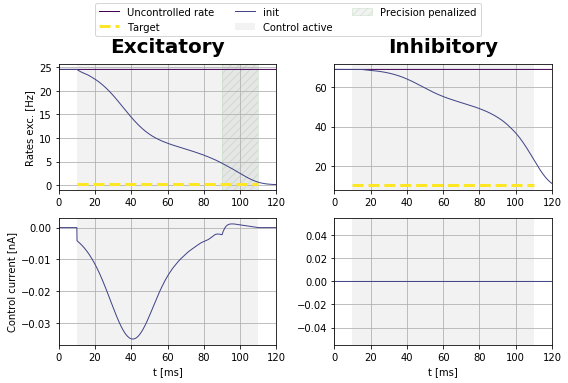

--------- 2


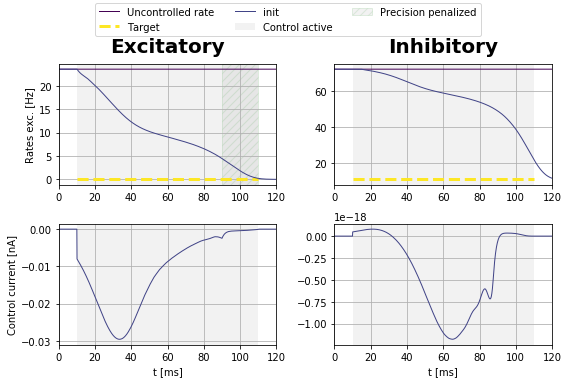

--------- 4


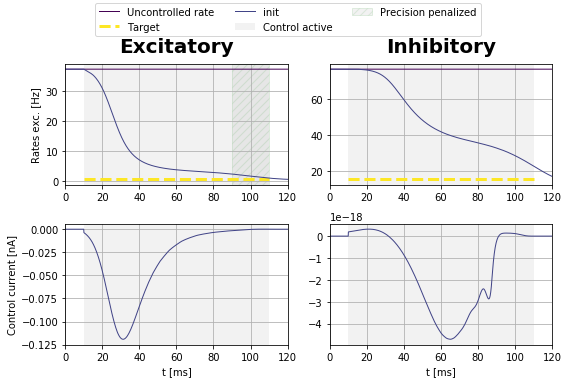

--------- 6


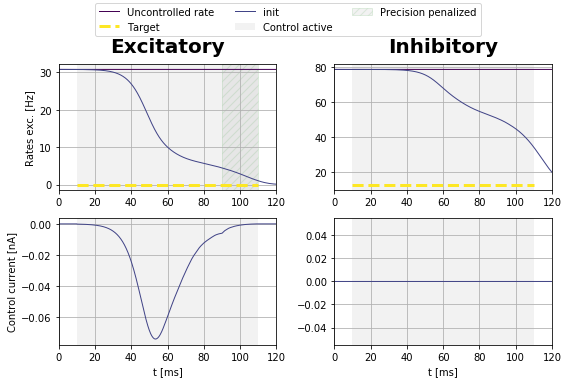

--------- 8


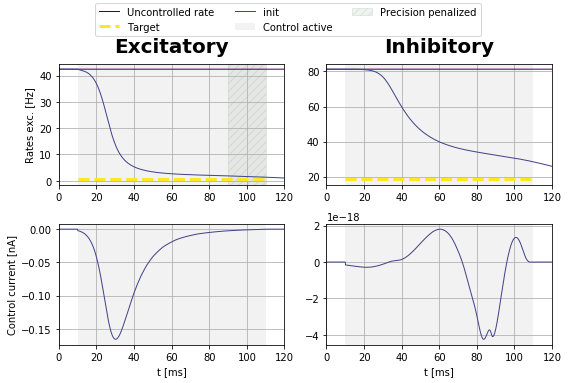

--------- 10


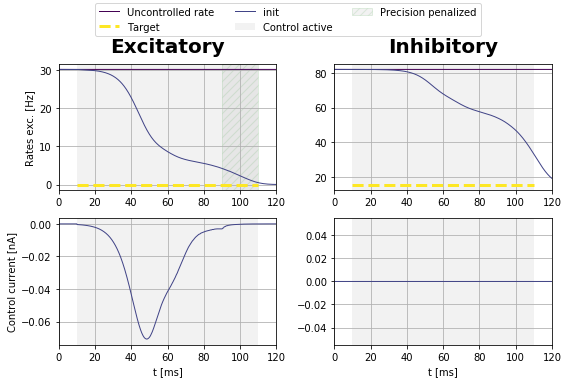

--------- 12


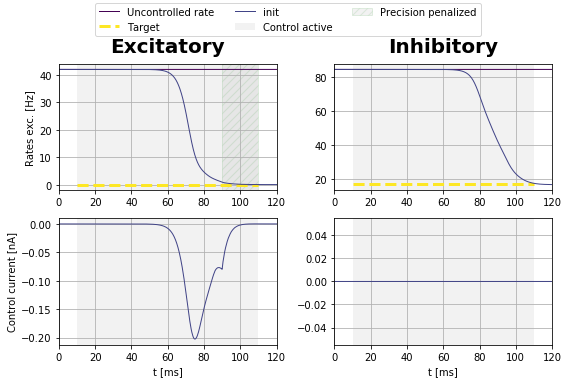

--------- 14


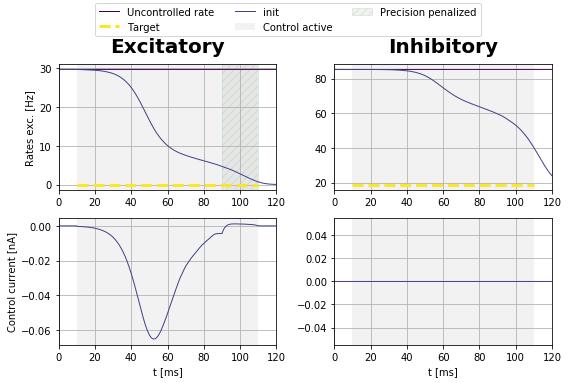

--------- 16


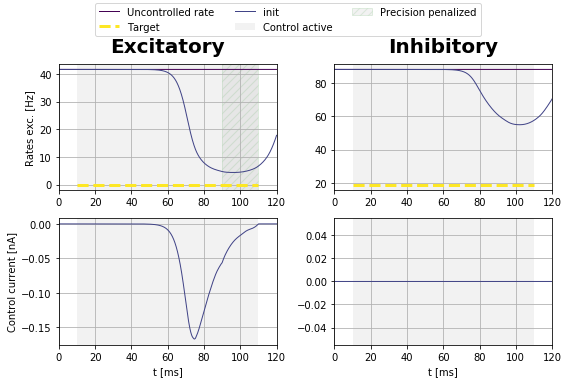

--------- 18


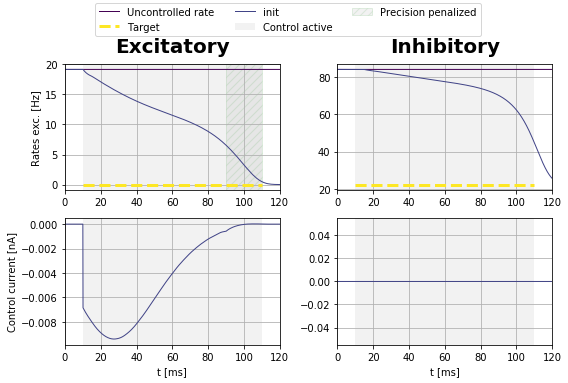

--------- 20


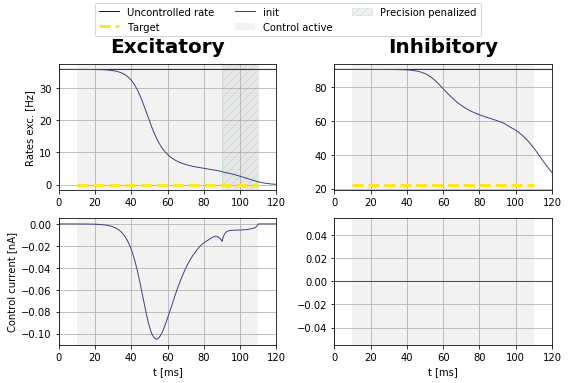

--------- 22


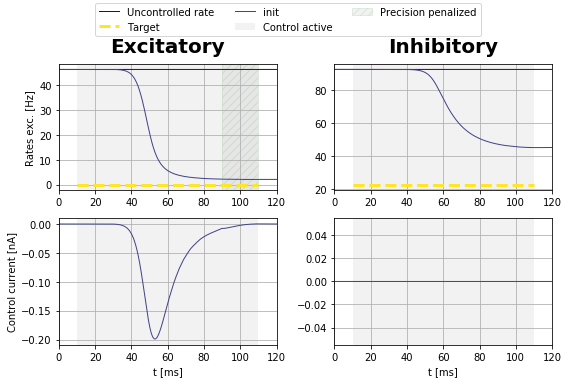

--------- 24


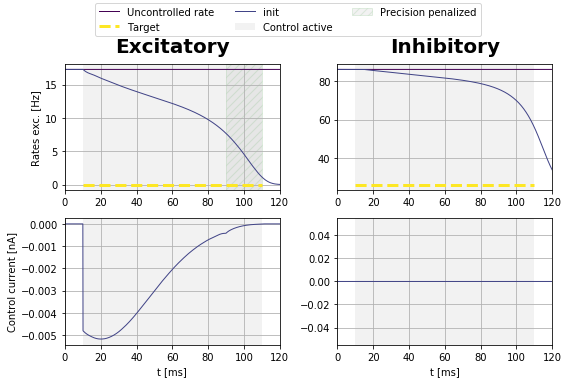

--------- 26


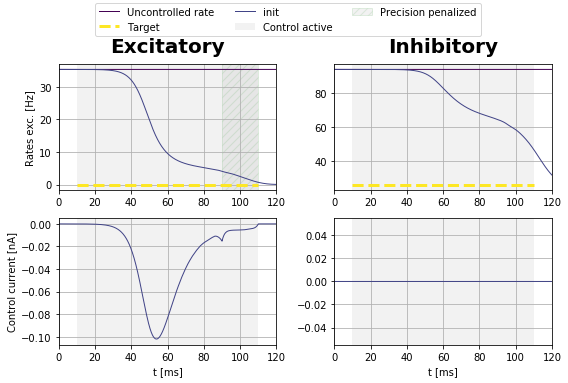

--------- 28


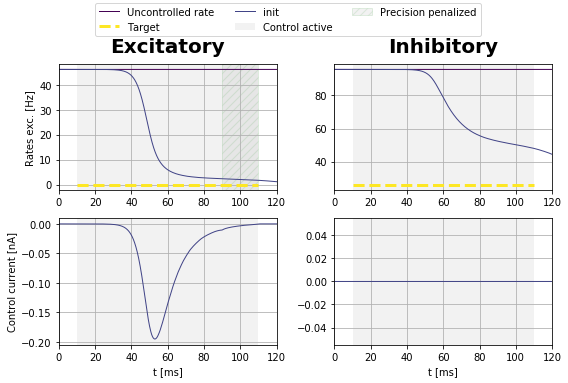

--------- 30


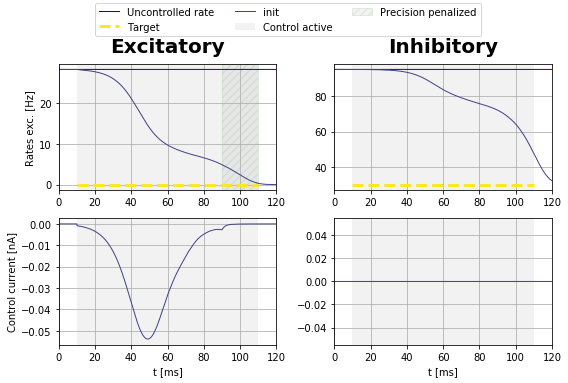

--------- 32


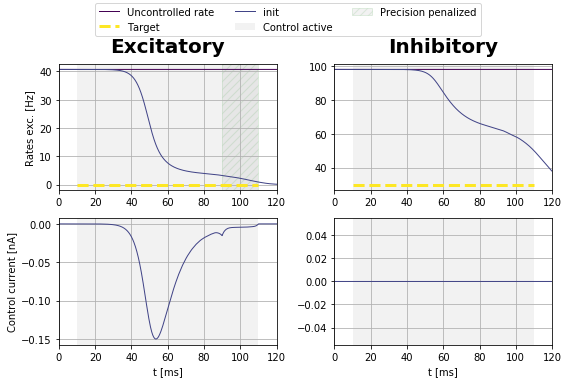

--------- 34


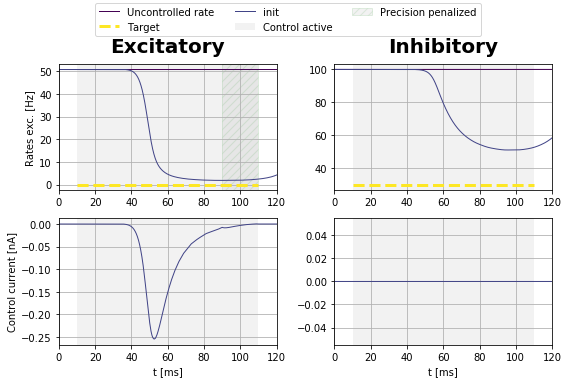

--------- 36


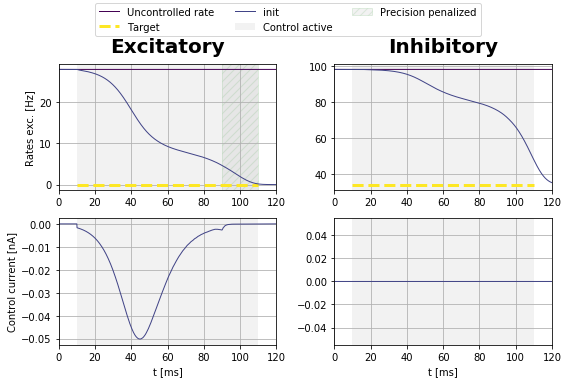

--------- 38


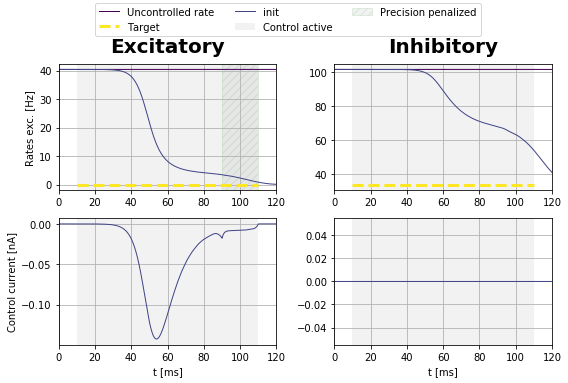

In [32]:
#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [34]:
found_solution = []
no_solution = []
factor_iteration = 0.1
already_tried = [ [] for _ in range(len(exc)) ]
factor_ = 6.

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])

        if np.abs(np.mean(bestState_init[i][0,0,-10:]) - target[i][0,0,-1]) < 0.2 * np.abs(
            np.mean(bestState_init[i][0,0,-10:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - target[i][0,1,-1]) < 0.3 * np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 1. and np.amax(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = factor_ * bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(50 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
        

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
found solution for  0
-------  2 0.4000000000000001 0.3750000000000001
found solution for  2
-------  4 0.4500000000000001 0.3750000000000001
found solution for  4
-------  6 0.4250000000000001 0.40000000000000013
found solution for  6
-------  8 0.47500000000000014 0.40000000000000013
found solution for  8
-------  10 0.4250000000000001 0.42500000000000016
found solution for  10
-------  12 0.47500000000000014 0.42500000000000016
found solution for  12
-------  14 0.4250000000000001 0.4500000000000002
found solution for  14
-------  16 0.47500000000000014 0.4500000000000002
[0, 2, 4, 6, 8, 10, 12, 14] []
closest index  12
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  190.729199510

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  34.68597562214255
RUN  10 , total integrated cost =  34.68597562214255
Improved over  10  iterations in  1.028596899996046  seconds by  81.81401918992059  percent.
Problem in initial value trasfer:  Vmean_exc -65.08914214134795 -65.09916158174481
weight =  4999.397492528296
set cost params:  1.0 0.0 4999.397492528296
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16840.131208574043
Gradient descend method:  None
RUN  1 , total integrated cost =  15188.527131795085
RUN  2 , total integrated cost =  15175.15558926892
RUN  3 , total integrated cost =  15166.904427424135


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15145.461702019365
RUN  5 , total integrated cost =  15126.085322528952
RUN  5 , total integrated cost =  15126.085322528952
Improved over  5  iterations in  0.6138382000062848  seconds by  10.178340446494829  percent.
Problem in initial value trasfer:  Vmean_exc -57.385395578904934 -57.37624308659133
-------  18 0.4000000000000001 0.4750000000000002
found solution for  18
-------  20 0.4500000000000001 0.4750000000000002
found solution for  20
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20] []
closest index  20
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  129.64334574915557
Gradient descend method:  None
RUN  1 , total integrated cost =  42.14092605596575
RUN  2 , total integrated cost =  37.643748247214475
RUN  3 , total integrated cost =  37.643056943327515
RUN  4 , total integrated cost =  37.631562437338644
RUN  5 , total integrate

ERROR:root:Problem in initial value trasfer


 10 , total integrated cost =  37.5660360203539
RUN  10 , total integrated cost =  37.5660360203539
Improved over  10  iterations in  1.0050886999961222  seconds by  71.02355249837527  percent.
Problem in initial value trasfer:  Vmean_exc -65.18396313809247 -65.18868395762834
weight =  5740.605044574103
set cost params:  1.0 0.0 5740.605044574103
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21454.35245882012
Gradient descend method:  None
RUN  1 , total integrated cost =  21073.850054483944
RUN  2 , total integrated cost =  21070.78311175892
RUN  3 , total integrated cost =  21070.26852905481


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21062.48986963934
RUN  5 , total integrated cost =  21055.607507755107
RUN  5 , total integrated cost =  21055.607507755107
Improved over  5  iterations in  0.5839740000010352  seconds by  1.8585736942206665  percent.
Problem in initial value trasfer:  Vmean_exc -59.38257169568274 -59.382692666719045
-------  24 0.4000000000000001 0.5000000000000002
found solution for  24
-------  26 0.4500000000000001 0.5000000000000002
found solution for  26
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26] []
closest index  26
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  126.03839818270457
Gradient descend method:  None
RUN  1 , total integrated cost =  38.53853185906362
RUN  2 , total integrated cost =  37.01086458193685
RUN  3 , total integrated cost =  36.99381318259349
RUN  4 , total integrated cost =  36.98932874448059
RUN  5 , total integ

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  36.965814631581715
RUN  10 , total integrated cost =  36.96301611713213
RUN  10 , total integrated cost =  36.96301611713213
Improved over  10  iterations in  0.9772494999997434  seconds by  70.6732101882549  percent.
Problem in initial value trasfer:  Vmean_exc -65.97941251260266 -65.98838488520425
weight =  5766.058893685297
set cost params:  1.0 0.0 5766.058893685297
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21180.72075109965
Gradient descend method:  None
RUN  1 , total integrated cost =  20831.182326181137
RUN  2 , total integrated cost =  20829.200108838722
RUN  3 , total integrated cost =  20828.691714125267
RUN  4 , total integrated cost =  20791.773947619255


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20745.880931963206
RUN  5 , total integrated cost =  20745.880931963206
Improved over  5  iterations in  0.5541841000012937  seconds by  2.052998215907593  percent.
Problem in initial value trasfer:  Vmean_exc -59.764873061672006 -59.77004828234009
-------  30 0.4250000000000001 0.5250000000000002
found solution for  30
-------  32 0.47500000000000014 0.5250000000000002
found solution for  32
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32] []
closest index  32
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  167.9833550255689
Gradient descend method:  None
RUN  1 , total integrated cost =  43.14756901775865
RUN  2 , total integrated cost =  43.14343507355564
RUN  3 , total integrated cost =  43.14335618663334
RUN  4 , total integrated cost =  43.14333076736538
RUN  5 , total integrated cost =  43.14329889284287
RUN  6 , tota

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  43.12967268710844
RUN  10 , total integrated cost =  43.12967268710844
Improved over  10  iterations in  1.0850410999992164  seconds by  74.32503197680292  percent.
Problem in initial value trasfer:  Vmean_exc -65.03585153284268 -65.04309035852488
weight =  5972.614375590462
set cost params:  1.0 0.0 5972.614375590462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25636.61211590381
Gradient descend method:  None
RUN  1 , total integrated cost =  25263.57830038361
RUN  2 , total integrated cost =  25262.66305603891
RUN  3 , total integrated cost =  25261.894534270567


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25260.677398523247
RUN  5 , total integrated cost =  25260.444041135936
RUN  5 , total integrated cost =  25260.444041135936
Improved over  5  iterations in  0.606318400001328  seconds by  1.4673080556323441  percent.
Problem in initial value trasfer:  Vmean_exc -58.94178873051035 -58.934894906334925
-------  36 0.4250000000000001 0.5500000000000003
found solution for  36
-------  38 0.47500000000000014 0.5500000000000003
found solution for  38
------------------------------------------------------------
-------------------- 1
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  30.917346455449678
RUN  10 , total integrated cost =  30.917346455449678
Improved over  10  iterations in  1.015882600004261  seconds by  76.15165635817371  percent.
Problem in initial value trasfer:  Vmean_exc -65.76173015782969 -65.76630262513012
weight =  5608.792455753296
set cost params:  1.0 0.0 5608.792455753296
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17242.782310804305
Gradient descend method:  None
RUN  1 , total integrated cost =  16831.057149942888
RUN  2 , total integrated cost =  16828.566350945453
RUN  3 , total integrated cost =  16828.414602254183


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16828.044564986878
RUN  5 , total integrated cost =  16826.687079188316
RUN  5 , total integrated cost =  16826.687079188316
Improved over  5  iterations in  0.6191934000016772  seconds by  2.4131559751540976  percent.
Problem in initial value trasfer:  Vmean_exc -60.0586558672617 -60.069733538366634
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38] [20]
closest index  12
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  190.73106198130907
Gradient descend method:  None
RUN  1 , total integrated cost =  40.927234350509124
RUN  2 , total integrated cost =  41.08343698063379
RUN  3 , total integrated cost =  40.95614567394963
RUN  4 , total integrated cost =  40.93900305313023
RUN  5 , total integrated cost =  40.7602492724

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  40.534779096927515
Improved over  10  iterations in  0.9732666999989306  seconds by  78.74767818316883  percent.
Problem in initial value trasfer:  Vmean_exc -64.45461616773346 -64.46373567098716
weight =  5320.166550492986
set cost params:  1.0 0.0 5320.166550492986
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21089.666442626953
Gradient descend method:  None
RUN  1 , total integrated cost =  19482.866433060324
RUN  2 , total integrated cost =  19456.054354087344
RUN  3 , total integrated cost =  19409.18272242089


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19370.601174662293
RUN  5 , total integrated cost =  19344.463908371064
RUN  5 , total integrated cost =  19344.463908371064
Improved over  5  iterations in  0.5440394999968703  seconds by  8.27515474938211  percent.
Problem in initial value trasfer:  Vmean_exc -56.94425222429347 -56.9333320388708
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38] [26]
closest index  32
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  167.98231361640805
Gradient descend method:  None
RUN  1 , total integrated cost =  42.98216965060728
RUN  2 , total integrated cost =  36.68675784500388
RUN  3 , total integrated cost =  36.63697239911082
RUN  4 , total integrated cost =  36.636821917623024
RUN  5 , total integrated cost =  36.6368205021848

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  36.6368204655896
RUN  10 , total integrated cost =  36.63682046477505
RUN  10 , total integrated cost =  36.63682046477505
Improved over  10  iterations in  1.035248699998192  seconds by  78.19007270703737  percent.
Problem in initial value trasfer:  Vmean_exc -65.90399490251195 -65.91324084668479
weight =  5817.396955189935
set cost params:  1.0 0.0 5817.396955189935
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21202.70460387592
Gradient descend method:  None
RUN  1 , total integrated cost =  20825.447590129213
RUN  2 , total integrated cost =  20825.359642114163
RUN  3 , total integrated cost =  20825.33949868408
RUN  4 , total integrated cost =  20824.9515068964


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20823.92647848649
RUN  5 , total integrated cost =  20823.92647848649
Improved over  5  iterations in  0.6137908999953652  seconds by  1.786461361727362  percent.
Problem in initial value trasfer:  Vmean_exc -59.669532906831435 -59.67397049348752
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38] [32]
closest index  38
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  165.28520969134544
Gradient descend method:  None
RUN  1 , total integrated cost =  46.534219231651235
RUN  2 , total integrated cost =  43.342324617848256
RUN  3 , total integrated cost =  43.32423500345722
RUN  4 , total integrated cost =  43.32375636971542
RUN  5 , total integrated cost =  43.32299382510329
RUN  6 , total integrated cost =  43.23884293728

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  43.17522218519708
RUN  10 , total integrated cost =  43.17516826664206
RUN  10 , total integrated cost =  43.17516826664206
Improved over  10  iterations in  1.0523519999987911  seconds by  73.87838370579702  percent.
Problem in initial value trasfer:  Vmean_exc -65.17367857709948 -65.18034003586868
weight =  5966.320768332925
set cost params:  1.0 0.0 5966.320768332925
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25634.332550371546
Gradient descend method:  None
RUN  1 , total integrated cost =  25263.594523841588
RUN  2 , total integrated cost =  25262.855381883885
RUN  3 , total integrated cost =  25260.082056241212
RUN  4 , total integrated cost =  25256.967027810475


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25256.73468019447
RUN  5 , total integrated cost =  25256.73468019447
Improved over  5  iterations in  0.5914799999954994  seconds by  1.4730161958970314  percent.
Problem in initial value trasfer:  Vmean_exc -58.98960958569073 -58.98238623759154
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 2
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.42500000000000

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  37.55066726363728
RUN  10 , total integrated cost =  37.55066726363728
Improved over  10  iterations in  1.0123479999965639  seconds by  79.07967597302802  percent.
Problem in initial value trasfer:  Vmean_exc -65.08650854862178 -65.09181581639162
weight =  5742.954562406018
set cost params:  1.0 0.0 5742.954562406018
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21428.373516128886
Gradient descend method:  None
RUN  1 , total integrated cost =  21069.122232248028
RUN  2 , total integrated cost =  21067.513623397324
RUN  3 , total integrated cost =  21066.65367502516


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21062.814481208305
RUN  5 , total integrated cost =  21058.792183929163
RUN  5 , total integrated cost =  21058.792183929163
Improved over  5  iterations in  0.567231000000902  seconds by  1.7247288130456724  percent.
Problem in initial value trasfer:  Vmean_exc -59.49466175132718 -59.495655380992005
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16] [26, 32]
closest index  38
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  165.28416827744837
Gradient descend method:  None
RUN  1 , total integrated cost =  40.28398749113725
RUN  2 , total integrated cost =  36.76942643219639
RUN  3 , total integrated cost =  36.71590276914667
RUN  4 , total integrated cost =  36.68568245938806
RUN  5 , total integrated cost =  36.685

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  36.68556446949944
RUN  10 , total integrated cost =  36.68556446949944
Improved over  10  iterations in  1.0833768000011332  seconds by  77.8045502773632  percent.
Problem in initial value trasfer:  Vmean_exc -66.01534083124812 -66.02405744212057
weight =  5809.667396472005
set cost params:  1.0 0.0 5809.667396472005
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21202.183973725518
Gradient descend method:  None
RUN  1 , total integrated cost =  20821.954587866898
RUN  2 , total integrated cost =  20821.1120618807
RUN  3 , total integrated cost =  20821.055094904616


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20807.354514515413
RUN  5 , total integrated cost =  20794.65630969454
RUN  5 , total integrated cost =  20794.65630969454
Improved over  5  iterations in  0.5636833000025945  seconds by  1.9221022916129868  percent.
Problem in initial value trasfer:  Vmean_exc -59.609732427778354 -59.613719360727686
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16] [32, 38]
closest index  26
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  126.03943954423758
Gradient descend method:  None
RUN  1 , total integrated cost =  44.78912509879511
RUN  2 , total integrated cost =  43.704068522223686
RUN  3 , total integrated cost =  43.70225310835668
RUN  4 , total integrated cost =  43.65185924449538
RUN  5 , total integrated cost =  43.5

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  43.56227407799362
RUN  10 , total integrated cost =  43.56227407799362
Improved over  10  iterations in  1.021315300000424  seconds by  65.43758506423376  percent.
Problem in initial value trasfer:  Vmean_exc -65.1699931027619 -65.17668172834789
weight =  5913.302474621396
set cost params:  1.0 0.0 5913.302474621396
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25631.711651404228
Gradient descend method:  None
RUN  1 , total integrated cost =  25284.05321935419
RUN  2 , total integrated cost =  25281.36148313587
RUN  3 , total integrated cost =  25280.571873938345


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25277.653277213303
RUN  5 , total integrated cost =  25275.633008452
RUN  5 , total integrated cost =  25275.633008452
Improved over  5  iterations in  0.5656665000060457  seconds by  1.389211332411037  percent.
Problem in initial value trasfer:  Vmean_exc -59.055385914768806 -59.048861862872755
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 3
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.475000000000

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  37.284655181191006
RUN  9 , total integrated cost =  37.284655181191006
Control only changes marginally.
RUN  9 , total integrated cost =  37.284655181191006
Improved over  9  iterations in  0.9420689000035054  seconds by  77.80498905486039  percent.
Problem in initial value trasfer:  Vmean_exc -65.02127625130929 -65.02676673493072
weight =  5783.92839722133
set cost params:  1.0 0.0 5783.92839722133
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21448.205418068566
Gradient descend method:  None
RUN  1 , total integrated cost =  21055.60592545031
RUN  2 , total integrated cost =  21054.309564618303
RUN  3 , total integrated cost =  21054.246636650983
RUN  4 , total integrated cost =  21054.216324289162


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21036.1643857561
RUN  5 , total integrated cost =  21036.1643857561
Improved over  5  iterations in  0.605685700000322  seconds by  1.9210979393425163  percent.
Problem in initial value trasfer:  Vmean_exc -60.573284856019754 -60.58197932796957
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16] [26, 32, 38]
closest index  16
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  179.48938164867337
Gradient descend method:  None
RUN  1 , total integrated cost =  41.989240755285564
RUN  2 , total integrated cost =  36.99641626223036
RUN  3 , total integrated cost =  36.951216644043384
RUN  4 , total integrated cost =  36.95069146846265
RUN  5 , total integrated cost =  36.950022227722016
RUN  6 , total integrated cost =  36.6

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  36.60642726604447
RUN  10 , total integrated cost =  36.60642726604444
RUN  10 , total integrated cost =  36.60642726604444
Improved over  10  iterations in  1.034162899995863  seconds by  79.60524075028758  percent.
Problem in initial value trasfer:  Vmean_exc -65.76485898660538 -65.77472497262393
weight =  5822.226962239488
set cost params:  1.0 0.0 5822.226962239488
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21208.027277435325
Gradient descend method:  None
RUN  1 , total integrated cost =  20851.474860307724
RUN  2 , total integrated cost =  20849.423229575645
RUN  3 , total integrated cost =  20849.392552224002
RUN  4 , total integrated cost =  20849.328730168607


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20848.410032493684
RUN  5 , total integrated cost =  20848.410032493684
Improved over  5  iterations in  0.5991956999932881  seconds by  1.6956657035435967  percent.
Problem in initial value trasfer:  Vmean_exc -59.839893501871735 -59.84608826338516
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16] [32, 38, 26]
closest index  20
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  129.64005165660257
Gradient descend method:  None
RUN  1 , total integrated cost =  43.9375386638054
RUN  2 , total integrated cost =  43.69837602549587
RUN  3 , total integrated cost =  43.69526890558792
RUN  4 , total integrated cost =  43.690403374116876
RUN  5 , total integrated cost =  43.67105574624678
RUN  6 , total integrated cost =  4

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  43.63018014346795
RUN  10 , total integrated cost =  43.63018014346795
Improved over  10  iterations in  0.9743497000017669  seconds by  66.34513826094587  percent.
Problem in initial value trasfer:  Vmean_exc -65.21004704851947 -65.21656272550868
weight =  5904.099003453256
set cost params:  1.0 0.0 5904.099003453256
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25633.60805519278
Gradient descend method:  None
RUN  1 , total integrated cost =  25281.994870518352
RUN  2 , total integrated cost =  25280.380243881267
RUN  3 , total integrated cost =  25279.118141641695


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25274.243133561016
RUN  5 , total integrated cost =  25269.677660770132
RUN  5 , total integrated cost =  25269.677660770132
Improved over  5  iterations in  0.5419413999989047  seconds by  1.4197392487200915  percent.
Problem in initial value trasfer:  Vmean_exc -59.06883720279566 -59.06236647937165
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 4
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.4750000

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  43.04805661933402
RUN  10 , total integrated cost =  43.04805661933402
Improved over  10  iterations in  1.0631757000010111  seconds by  79.09875110820994  percent.
Problem in initial value trasfer:  Vmean_exc -64.84176255007795 -64.84979847482342
weight =  5983.938029616918
set cost params:  1.0 0.0 5983.938029616918
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25639.774409667712
Gradient descend method:  None
RUN  1 , total integrated cost =  25283.68512276334
RUN  2 , total integrated cost =  25281.236989272646
RUN  3 , total integrated cost =  25280.91341564067


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25279.924136205012
RUN  5 , total integrated cost =  25279.54938532856
RUN  5 , total integrated cost =  25279.54938532856
Improved over  5  iterations in  0.593518400004541  seconds by  1.4049461535173435  percent.
Problem in initial value trasfer:  Vmean_exc -59.0127495879977 -59.006725367290954
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 5
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16, 22, 28]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  43.15865318320177
RUN  10 , total integrated cost =  43.13034066260968
RUN  10 , total integrated cost =  43.13034066260968
Improved over  10  iterations in  1.0552490999980364  seconds by  78.97061725636567  percent.
Problem in initial value trasfer:  Vmean_exc -64.89876963522569 -64.90658589551374
weight =  5972.52187550769
set cost params:  1.0 0.0 5972.52187550769
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25639.858912853688
Gradient descend method:  None
RUN  1 , total integrated cost =  25257.853013226468
RUN  2 , total integrated cost =  25255.937321797315
RUN  3 , total integrated cost =  25255.584135286208


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25252.69222917044
RUN  5 , total integrated cost =  25250.882567699093
RUN  5 , total integrated cost =  25250.882567699093
Improved over  5  iterations in  0.5728038999950513  seconds by  1.51707677673528  percent.
Problem in initial value trasfer:  Vmean_exc -58.99663557976759 -58.990315808174756
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 6
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16, 22, 28]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.4

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  43.49479611391777
RUN  10 , total integrated cost =  43.485714904373424
RUN  10 , total integrated cost =  43.485714904373424
Improved over  10  iterations in  0.9574530999962008  seconds by  75.77268237371298  percent.
Problem in initial value trasfer:  Vmean_exc -65.17713294344682 -65.18376397987339
weight =  5923.713193447539
set cost params:  1.0 0.0 5923.713193447539
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25646.4327240885
Gradient descend method:  None
RUN  1 , total integrated cost =  25285.46128166782
RUN  2 , total integrated cost =  25283.762727174457
RUN  3 , total integrated cost =  25281.669990097806
RUN  4 , total integrated cost =  25280.95768879986


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25278.904263232787
RUN  5 , total integrated cost =  25278.904263232787
Improved over  5  iterations in  0.5818398999981582  seconds by  1.4330587992867692  percent.
Problem in initial value trasfer:  Vmean_exc -59.50272990327141 -59.50006347038888
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 7
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16, 22, 28]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  44.17423511594801
Improved over  10  iterations in  0.9240156000014395  seconds by  38.71366192427045  percent.
Problem in initial value trasfer:  Vmean_exc -64.8113292335958 -64.81943181879151
weight =  5831.383439450573
set cost params:  1.0 0.0 5831.383439450573
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25663.894727780124
Gradient descend method:  None
RUN  1 , total integrated cost =  25415.402934675516
RUN  2 , total integrated cost =  25414.068722370455
RUN  3 , total integrated cost =  25412.06201389456
RUN  4 , total integrated cost =  25410.145251383998


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25407.034521227473
RUN  5 , total integrated cost =  25407.034521227473
Improved over  5  iterations in  0.5231229999990319  seconds by  1.0008621422320942  percent.
Problem in initial value trasfer:  Vmean_exc -60.11450088269549 -60.11722519990609
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------------------
-------------------- 8
------------------------------------------------------------
found solution:  [0, 2, 4, 6, 8, 10, 12, 14, 18, 20, 24, 26, 30, 32, 36, 38, 16, 22, 28]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.

In [35]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[::i_stepsize])
    full_converge = True
    
    for conv in conv_init[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.5201228074475
Improved over  1  iterations in  0.1794240000017453  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.41963068311124 -61.452666692690165
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  7378.427785878826
set cost params:  1.0 0.0 7378.427785878826
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5537.957201564957
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.957201564957
Control only changes marginally.
RUN  1 , total integrated cost =  5537.957201564957
Improved over  1  iterations in  0.1766005999961635  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.851258824711735 -62.89244727929834
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  5478.367901553496
set cost params:  1.0 0.0 5478.367901553496
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.246219397815
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.236544987813
RUN  2 , total integrated cost =  13599.236425543075
RUN  3 , total integrated cost =  13599.236424517494
RUN  4 , total integrated cost =  13599.236424506027
RUN  5 , total integrated cost =  13599.236424506022


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13599.236424506014
RUN  7 , total integrated cost =  13599.236424506014
Control only changes marginally.
RUN  7 , total integrated cost =  13599.236424506014
Improved over  7  iterations in  1.0307179000010365  seconds by  7.202525524974135e-05  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5924.826362374838
set cost params:  1.0 0.0 5924.826362374838
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.483865931283
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  9437.483865931283
Control only changes marginally.
RUN  1 , total integrated cost =  9437.483865931283
Improved over  1  iterations in  0.19755000000441214  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.46334346083471 -60.489473597487645
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.9426866104795
set cost params:  1.0 0.0 5584.9426866104795
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17547.82877410183
Gradient descend method:  None
RUN  1 , total integrated cost =  17547.828774101825
RUN  2 , total integrated cost =  17547.82877410182


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17547.82877410182
Control only changes marginally.
RUN  3 , total integrated cost =  17547.82877410182
Improved over  3  iterations in  0.4885322999980417  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  6077.550155239316
set cost params:  1.0 0.0 6077.550155239316
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.957537951313
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.957537951313
Control only changes marginally.
RUN  1 , total integrated cost =  9109.957537951313
Improved over  1  iterations in  0.17240100000344682  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.65275298859355 -61.68902526869219
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557649.178138812
set cost params:  1.0 0.0 2557649.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8676735.515825951
Gradient descend method:  None
RUN  1 , total integrated cost =  116318.07355343262
RUN  2 , total integrated cost =  18942.9341542624
RUN  3 , total integrated cost =  17612.72258084492
RUN  4 , total integrated cost =  17571.304210723556
RUN  5 , total integrated cost =  17571.200383096064
RUN  6 , total integrated cost =  17571.200176275288
RUN  7 , total integrated cost =  17571.200166346895
RUN  8 , total integrated cost =  17571.20016629529
RUN  9 , total in

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8794.752012673302
Control only changes marginally.
RUN  3 , total integrated cost =  8794.752012673302
Improved over  3  iterations in  0.5176447000048938  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -61.1108075669502 -61.14710179282749
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  5779.192926210719
set cost params:  1.0 0.0 5779.192926210719
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17336.437778732237
Gradient descend method:  None
RUN  1 , total integrated cost =  17335.94108107717
RUN  2 , total integrated cost =  17335.76212704979
RUN  3 , total integrated cost =  17333.77146339943
RUN  4 , total integrated cost =  17332.890927684148
RUN  5 , total integrated cost =  17332.7751048549
RUN  6 , total integrated cost =  17319.257017457938
RUN  7 , total integrated cost =  17306.54177335761
RUN  8 , total integrated cost =  17306.407560406937
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  48 , total integrated cost =  17259.066605779277
Improved over  48  iterations in  5.920917899995402  seconds by  0.4462922195462653  percent.
Problem in initial value trasfer:  Vmean_exc -59.77929174223229 -59.78860910577671
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  12451.441489276787
set cost params:  1.0 0.0 12451.441489276787
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.864429803867
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.864429803867
Control only changes marginally.
RUN  1 , total integrated cost =  3670.864429803867
Improved over  1  iterations in  0.17160589999548392  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.62480947729378 -61.67442206498571
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  5859.921195075771
set cost params:  1.0 0.0 5859.921195075771
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12732.799682744773
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12732.79968274477
RUN  2 , total integrated cost =  12732.79968274477
Control only changes marginally.
RUN  2 , total integrated cost =  12732.79968274477
Improved over  2  iterations in  0.3389458999954513  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  5928.381457420177
set cost params:  1.0 0.0 5928.381457420177
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21560.99637847307
Gradient descend method:  None
RUN  1 , total integrated cost =  21547.555087125038
RUN  2 , total integrated cost =  21547.50076357487
RUN  3 , total integrated cost =  21547.49889485042
RUN  4 , total integrated cost =  21547.49844012045
RUN  5 , total integrated cost =  21547.498185316163
RUN  6 , total integrated cost =  21547.49784922739
RUN  7 , total integrated cost =  21547.496410168467
RUN  8

ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  21543.08837619213
Control only changes marginally.
RUN  51 , total integrated cost =  21543.08837619213
Improved over  51  iterations in  6.519194900000002  seconds by  0.08305739663693146  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17853.40700747526
set cost params:  1.0 0.0 17853.40700747526
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.8146496495233
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.8146496495233
Control only changes marginally.
RUN  1 , total integrated cost =  2980.8146496495233
Improved over  1  iterations in  0.17880220000370173  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.18555897405015 -60.22393494191988
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5905.618262948788
set cost params:  1.0 0.0 5905.618262948788
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12474.50428128397
Gradient descend method:  None
RUN  1 , total integrated cost =  12474.465463870289
RUN  2 , total integrated cost =  12474.46481435183
RUN  3 , total integrated cost =  12474.464799689884
RUN  4 , total integrated cost =  12474.464799689882


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12474.464799689882
Control only changes marginally.
RUN  5 , total integrated cost =  12474.464799689882
Improved over  5  iterations in  0.7096931999985827  seconds by  0.0003164983008332456  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  5950.996495197966
set cost params:  1.0 0.0 5950.996495197966
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21308.69883244877
Gradient descend method:  None
RUN  1 , total integrated cost =  21308.20874636994
RUN  2 , total integrated cost =  21308.18323322726
RUN  3 , total integrated cost =  21308.09450381604
RUN  4 , total integrated cost =  21307.292838748075
RUN  5 , total integrated cost =  21306.99686470484
RUN  6 , total integrated cost =  21306.97324180373
RUN  7 , total integrated cost =  21306.813247597984
RUN  8 , total integrated cost =  21306.117970659794
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  32 , total integrated cost =  21246.128793852386
Improved over  32  iterations in  4.2806081000017  seconds by  0.29363612995976496  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  6575.264785285024
set cost params:  1.0 0.0 6575.264785285024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.103982889001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.103982889001
Control only changes marginally.
RUN  1 , total integrated cost =  7977.103982889001
Improved over  1  iterations in  0.19121779999841237  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.37500976425875 -62.424368160750824
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.331984333735
set cost params:  1.0 0.0 5898.331984333735
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16563.953692699917
Gradient descend method:  None
RUN  1 , total integrated cost =  16563.941529396143
RUN  2 , total integrated cost =  16563.94150613453


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16563.941506134528
RUN  4 , total integrated cost =  16563.941506134528
Control only changes marginally.
RUN  4 , total integrated cost =  16563.941506134528
Improved over  4  iterations in  0.5714518000022508  seconds by  7.357280523478948e-05  percent.
Problem in initial value trasfer:  Vmean_exc -60.6134965043117 -60.63512807103068
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  5911.324453168018
set cost params:  1.0 0.0 5911.324453168018
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.068874161112
Gradient descend method:  None
RUN  1 , total integrated cost =  25751.94723211038
RUN  2 , total integrated cost =  25624.08994113931
RUN  3 , total integrated cost =  25347.502784280703
RUN  4 , total integrated cost =  25346.337354756146
RUN  5 , total integrated cost =  25341.746997479433
RUN  6 , total integrated cost =  25336.66831456838
RUN  7 , total integrated cost =  25219.055561875724
RU

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  83 , total integrated cost =  24866.081654383303
Improved over  83  iterations in  10.006380999999237  seconds by  3.451698087554675  percent.
Problem in initial value trasfer:  Vmean_exc -59.54638349521252 -59.54493346564412
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6745.793915779273
set cost params:  1.0 0.0 6745.793915779273
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.52027451595
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.52027451595
Control only changes marginally.
RUN  1 , total integrated cost =  7740.52027451595
Improved over  1  iterations in  0.175213900001836  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.379103693374205 -63.434079395850205
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  5911.569216828507
set cost params:  1.0 0.0 5911.569216828507
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.153744851605
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.15054597482
RUN  2 , total integrated cost =  16340.149769807591
RUN  3 , total integrated cost =  16340.14960556984
RUN  4 , total integrated cost =  16340.149501969954
RUN  5 , total integrated cost =  16340.14948071293
RUN  6 , total integrated cost =  16340.149468894811
RUN  7 , total integrated cost =  16340.149467540616
RUN  8 , total integrated cost =  16340.149467540605
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  16340.149467540596
RUN  11 , total integrated cost =  16340.149467540596
Control only changes marginally.
RUN  11 , total integrated cost =  16340.149467540596
Improved over  11  iterations in  1.371828800001822  seconds by  2.6176687669021703e-05  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
no convergence
------------------------------------------------
------------------------- 1
[[True, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.5201228074475
Control only changes marginally.
RUN  1 , total integrated cost =  5901.5201228074475
Improved over  1  iterations in  0.18549110000458313  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.41963068311124 -61.452666692690165
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  7378.427785879199
set cost params:  1.0 0.0 7378.427785879199
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5537.957201565234
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.957201565234
Control only changes marginally.
RUN  1 , total integrated cost =  5537.957201565234
Improved over  1  iterations in  0.18892919999780133  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.851258824711735 -62.89244727929834
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  5478.588599129324
set cost params:  1.0 0.0 5478.588599129324
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.78380434409
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.78380434409
Control only changes marginally.
RUN  1 , total integrated cost =  13599.78380434409
Improved over  1  iterations in  0.182523499999661  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5924.8263623750945
set cost params:  1.0 0.0 5924.8263623750945
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.483865931687
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.483865931687
Control only changes marginally.
RUN  1 , total integrated cost =  9437.483865931687
Improved over  1  iterations in  0.18441089999396354  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.46334346083471 -60.489473597487645
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.999039404596
set cost params:  1.0 0.0 5584.999039404596
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17548.005717196866
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17548.005717196866
Control only changes marginally.
RUN  1 , total integrated cost =  17548.005717196866
Improved over  1  iterations in  0.1912817999982508  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  6077.550155239316
set cost params:  1.0 0.0 6077.550155239316
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.957537951313
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.957537951313
Control only changes marginally.
RUN  1 , total integrated cost =  9109.957537951313
Improved over  1  iterations in  0.17120569999678992  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.65275298859355 -61.68902526869219
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557648.178138812
set cost params:  1.0 0.0 2557648.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17571.20016629342
Control only changes marginally.
RUN  1 , total integrated cost =  17571.20016629342
Improved over  1  iterations in  0.1925247000035597  seconds by  0.0  percent.
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  6178.050803593371
set cost params:  1.0 0.0 6178.050803593371
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.7520126

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.752012673862
Control only changes marginally.
RUN  1 , total integrated cost =  8794.752012673862
Improved over  1  iterations in  0.18122100000618957  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.1108075669502 -61.14710179282749
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5805.594127334495
set cost params:  1.0 0.0 5805.594127334495
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.67796240733
Gradient descend method:  None
RUN  1 , total integrated cost =  17337.677483581854
RUN  2 , total integrated cost =  17337.6774604639
RUN  3 , total integrated cost =  17337.67745881544
RUN  4 , total integrated cost =  17337.67745873572
RUN  5 , total integrated cost =  17337.677458735423
RUN  6 , total integrated cost =  17337.677458735412


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17337.6774587354
RUN  8 , total integrated cost =  17337.6774587354
Control only changes marginally.
RUN  8 , total integrated cost =  17337.6774587354
Improved over  8  iterations in  1.1297865000015008  seconds by  2.9050714402956146e-06  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164801037 -59.7766404358063
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  12451.441489560822
set cost params:  1.0 0.0 12451.441489560822
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.8644298842582
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.8644298842582
Control only changes marginally.
RUN  1 , total integrated cost =  3670.8644298842582
Improved over  1  iterations in  0.1729676999966614  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.62480947729378 -61.67442206498571
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  5861.3680912411155
set cost params:  1.0 0.0 5861.3680912411155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.925914507723
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.925914507723
Control only changes marginally.
RUN  1 , total integrated cost =  12735.925914507723
Improved over  1  iterations in  0.1764030999984243  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  5933.4601251227605
set cost params:  1.0 0.0 5933.4601251227605
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21561.50482620402
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21561.50482620402
Control only changes marginally.
RUN  1 , total integrated cost =  21561.50482620402
Improved over  1  iterations in  0.18925810000655474  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17853.40709093698
set cost params:  1.0 0.0 17853.40709093698
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.8146624619917
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.8146624619917
Control only changes marginally.
RUN  1 , total integrated cost =  2980.8146624619917
Improved over  1  iterations in  0.17348929999570828  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.18555897405015 -60.22393494191988
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5907.089409251621
set cost params:  1.0 0.0 5907.089409251621
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.554515357902
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.554515357902
Control only changes marginally.
RUN  1 , total integrated cost =  12477.554515357902
Improved over  1  iterations in  0.1819009000028018  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  5968.752969020233
set cost params:  1.0 0.0 5968.752969020233
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.395952532104
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.395952532104
Control only changes marginally.
RUN  1 , total integrated cost =  21309.395952532104
Improved over  1  iterations in  0.18931249999877764  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  6575.264785285024
set cost params:  1.0 0.0 6575.264785285024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.103982889001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.103982889001
Control only changes marginally.
RUN  1 , total integrated cost =  7977.103982889001
Improved over  1  iterations in  0.18770799999765586  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.37500976425875 -62.424368160750824
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.854956374795
set cost params:  1.0 0.0 5898.854956374795
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.40557917604
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.405579176037
RUN  2 , total integrated cost =  16565.405579176037
Control only changes marginally.
RUN  2 , total integrated cost =  16565.405579176037
Improved over  2  iterations in  0.3545933999994304  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.7588356414
set cost params:  1.0 0.0 6122.7588356414
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25754.481631742045
Gradient descend method:  None
RUN  1 , total integrated cost =  25754.476159898873
RUN  2 , total integrated cost =  25754.47605091297
RUN  3 , total integrated cost =  25754.47603531378
RUN  4 , total integrated cost =  25754.47603503042
RUN  5 , total integrated cost =  25754.476035030417


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  25754.476035030417
Control only changes marginally.
RUN  6 , total integrated cost =  25754.476035030417
Improved over  6  iterations in  0.9052312999992864  seconds by  2.1731020282800273e-05  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6745.793915789398
set cost params:  1.0 0.0 6745.793915789398
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.5202745274755
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.5202745274755
Control only changes marginally.
RUN  1 , total integrated cost =  7740.5202745274755
Improved over  1  iterations in  0.1922054999959073  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.379103693374205 -63.434079395850205
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  5912.189538772875
set cost params:  1.0 0.0 5912.189538772875
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.858174876346
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.858174876346
Control only changes marginally.
RUN  1 , total integrated cost =  16341.858174876346
Improved over  1  iterations in  0.18133229999511968  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
no convergence
------------------------------------------------
------------------------- 2
[[True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.784273214515
Control only changes marginally.
RUN  1 , total integrated cost =  13599.784273214515
Improved over  1  iterations in  0.1880553000009968  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.99907657468
set cost params:  1.0 0.0 5584.99907657468
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17548.005833907842
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17548.005833907842
Control only changes marginally.
RUN  1 , total integrated cost =  17548.005833907842
Improved over  1  iterations in  0.1981770000056713  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557647.178138812
set cost params:  1.0 0.0 2557647.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17571.20016629342
Control only changes marginally.
RUN  1 , total integrated cost =  17571.20016629342
Improved over  1  iterations in  0.2097494999979972  seconds by  0.0  percent.
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  6178.050803593375
set cost params:  1.0 0.0 6178.050803593375
interpolate adjoint :  True 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.75201267387
Control only changes marginally.
RUN  1 , total integrated cost =  8794.75201267387
Improved over  1  iterations in  0.22141959999862593  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.1108075669502 -61.14710179282749
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  5805.672524078439
set cost params:  1.0 0.0 5805.672524078439
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.91088626594
Gradient descend method:  None
RUN  1 , total integrated cost =  17337.910886265938
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  17337.910886265938
Control only changes marginally.
RUN  2 , total integrated cost =  17337.910886265938
Improved over  2  iterations in  0.375266000002739  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
no convergence
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  5861.376226535976
set cost params:  1.0 0.0 5861.376226535976
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.943492007616
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.943492007616
Control only changes marginally.
RUN  1 , total integrated cost =  12735.943492007616
Improved over  1  iterations in  0.18791000000055647  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  5933.470823943561
set cost params:  1.0 0.0 5933.470823943561
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21561.543622658133
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21561.543622658133
Control only changes marginally.
RUN  1 , total integrated cost =  21561.543622658133
Improved over  1  iterations in  0.18454529999871738  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5907.09783441728
set cost params:  1.0 0.0 5907.09783441728
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.572209972157
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.572209972157
Control only changes marginally.
RUN  1 , total integrated cost =  12477.572209972157
Improved over  1  iterations in  0.18389359999855515  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  5968.788449410497
set cost params:  1.0 0.0 5968.788449410497
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.522370845974
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.522370845974
Control only changes marginally.
RUN  1 , total integrated cost =  21309.522370845974
Improved over  1  iterations in  0.18539120000059484  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.856580023075
set cost params:  1.0 0.0 5898.856580023075
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.410124619175
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.410124619175
Control only changes marginally.
RUN  1 , total integrated cost =  16565.410124619175
Improved over  1  iterations in  0.18772159999934956  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.9984551734415
set cost params:  1.0 0.0 6122.9984551734415
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.48284508827
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25755.48284508827
Control only changes marginally.
RUN  1 , total integrated cost =  25755.48284508827
Improved over  1  iterations in  0.18903640000644373  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  5912.1916818093905
set cost params:  1.0 0.0 5912.1916818093905
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.864077975935
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.864077975935
Control only changes marginally.
RUN  1 , total integrated cost =  16341.864077975935
Improved over  1  iterations in  0.1970115000003716  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
converged for  38
------------------------------------------------
------------------------- 3
[[True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [False, False], [True, True], [True, False], [True, False], [True, True], [True, False], [True, False], [True, True], [False, False], [False, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.784273616116
Control only changes marginally.
RUN  1 , total integrated cost =  13599.784273616116
Improved over  1  iterations in  0.1954916000031517  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.999076599197
set cost params:  1.0 0.0 5584.999076599197
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17548.005833984822
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17548.005833984822
Control only changes marginally.
RUN  1 , total integrated cost =  17548.005833984822
Improved over  1  iterations in  0.18508460000157356  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557646.178138812
set cost params:  1.0 0.0 2557646.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17571.20016629342
Control only changes marginally.
RUN  1 , total integrated cost =  17571.20016629342
Improved over  1  iterations in  0.19882859999779612  seconds by  0.0  percent.
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
weight =  5805.672756673291
set cost params:  1

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.911578820745
Control only changes marginally.
RUN  1 , total integrated cost =  17337.911578820745
Improved over  1  iterations in  0.18175799999880837  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
no convergence
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  5861.376272266062
set cost params:  1.0 0.0 5861.376272266062
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.943590814188
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.943590814188
Control only changes marginally.
RUN  1 , total integrated cost =  12735.943590814188
Improved over  1  iterations in  0.17895310000312747  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  5933.470846462616
set cost params:  1.0 0.0 5933.470846462616
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21561.543704317548
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21561.543704317548
Control only changes marginally.
RUN  1 , total integrated cost =  21561.543704317548
Improved over  1  iterations in  0.18042219999915687  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5907.097882655677
set cost params:  1.0 0.0 5907.097882655677
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.572311282904
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.572311282904
Control only changes marginally.
RUN  1 , total integrated cost =  12477.572311282904
Improved over  1  iterations in  0.1830513999957475  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  5968.788520095316
set cost params:  1.0 0.0 5968.788520095316
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.522622699336
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.522622699336
Control only changes marginally.
RUN  1 , total integrated cost =  21309.522622699336
Improved over  1  iterations in  0.17666669999744045  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.856585063498
set cost params:  1.0 0.0 5898.856585063498
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.410138729963
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.410138729963
Control only changes marginally.
RUN  1 , total integrated cost =  16565.410138729963
Improved over  1  iterations in  0.18261770000390243  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.998720037387
set cost params:  1.0 0.0 6122.998720037387
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.483957967852
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25755.483957967852
Control only changes marginally.
RUN  1 , total integrated cost =  25755.483957967852
Improved over  1  iterations in  0.19300829999701818  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  5912.191689212198
set cost params:  1.0 0.0 5912.191689212198
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.864098367334
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.864098367334
Control only changes marginally.
RUN  1 , total integrated cost =  16341.864098367334
Improved over  1  iterations in  0.18696739999722922  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
converged for  38
------------------------------------------------
------------------------- 4
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.911580875454
Control only changes marginally.
RUN  1 , total integrated cost =  17337.911580875454
Improved over  1  iterations in  0.18638780000037514  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.856585079146
set cost params:  1.0 0.0 5898.856585079146
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.41013877377
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.41013877377
Control only changes marginally.
RUN  1 , total integrated cost =  16565.41013877377
Improved over  1  iterations in  0.19154329999582842  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.998720330143
set cost params:  1.0 0.0 6122.998720330143
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.483959197925
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25755.483959197925
Control only changes marginally.
RUN  1 , total integrated cost =  25755.483959197925
Improved over  1  iterations in  0.18114040000364184  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 5
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.911580881548
Control only changes marginally.
RUN  1 , total integrated cost =  17337.911580881548
Improved over  1  iterations in  0.1892368999979226  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 6
[[True, True], [True, True], [True, True], [True, Tr

In [36]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [38]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

ERROR:root:Problem in initial value trasfer


--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  5537.9572015652375
Improved over  1  iterations in  0.1793448000025819  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.851258824711735 -62.89244727929834
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  5478.588788334822
set cost params:  1.0 0.0 5478.588788334822
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.784273616462
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.784273616462
Control only changes marginally.
RUN  1 , total integrated cost =  13599.784273616462
Improved over  1  iterations in  0.18263830000068992  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5924.826362375097
set cost params:  1.0 0.0 5924.826362375097
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.483865931692
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.483865931692
Control only changes marginally.
RUN  1 , total integrated cost =  9437.483865931692
Improved over  1  iterations in  0.1805677000011201  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.46334346083471 -60.489473597487645
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.999076599213
set cost params:  1.0 0.0 5584.999076599213
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17548.005833984877
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17548.005833984877
Control only changes marginally.
RUN  1 , total integrated cost =  17548.005833984877
Improved over  1  iterations in  0.18165920000319602  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  6077.550155239316
set cost params:  1.0 0.0 6077.550155239316
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.957537951313
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.957537951313
Control only changes marginally.
RUN  1 , total integrated cost =  9109.957537951313
Improved over  1  iterations in  0.19511119999515358  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.65275298859355 -61.68902526869219
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557645.178138812
set cost params:  1.0 0.0 2557645.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17571.20016629342
Control only changes marginally.
RUN  1 , total integrated cost =  17571.20016629342
Improved over  1  iterations in  0.21420639999996638  seconds by  0.0  percent.
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  6178.050803593375
set cost params:  1.0 0.0 6178.050803593375
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.752

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.75201267387
Control only changes marginally.
RUN  1 , total integrated cost =  8794.75201267387
Improved over  1  iterations in  0.17023989999870537  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.1108075669502 -61.14710179282749
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  5805.67275736542
set cost params:  1.0 0.0 5805.67275736542
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.91158088157
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.91158088157
Control only changes marginally.
RUN  1 , total integrated cost =  17337.91158088157
Improved over  1  iterations in  0.2031076999992365  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  12451.441489572175
set cost params:  1.0 0.0 12451.441489572175
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.8644298874715
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.8644298874715
Control only changes marginally.
RUN  1 , total integrated cost =  3670.8644298874715
Improved over  1  iterations in  0.18504680000478402  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.62480947729378 -61.67442206498571
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  5861.37627252312
set cost params:  1.0 0.0 5861.37627252312
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.9435913696
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.9435913696
Control only changes marginally.
RUN  1 , total integrated cost =  12735.9435913696
Improved over  1  iterations in  0.18258619999687653  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  5933.470846510014
set cost params:  1.0 0.0 5933.470846510014
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21561.543704489424
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21561.543704489424
Control only changes marginally.
RUN  1 , total integrated cost =  21561.543704489424
Improved over  1  iterations in  0.17847880000044825  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  17853.407097659583
set cost params:  1.0 0.0 17853.407097659583
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.8146634939994
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.8146634939994
Control only changes marginally.
RUN  1 , total integrated cost =  2980.8146634939994
Improved over  1  iterations in  0.18639260000054492  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.18555897405015 -60.22393494191988
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5907.097882931866
set cost params:  1.0 0.0 5907.097882931866
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.57231186296
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.57231186296
Control only changes marginally.
RUN  1 , total integrated cost =  12477.57231186296
Improved over  1  iterations in  0.18001129999902332  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  5968.788520236135
set cost params:  1.0 0.0 5968.788520236135
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.522623201083
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.522623201083
Control only changes marginally.
RUN  1 , total integrated cost =  21309.522623201083
Improved over  1  iterations in  0.1787419000029331  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  6575.264785285024
set cost params:  1.0 0.0 6575.264785285024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.103982889001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.103982889001
Control only changes marginally.
RUN  1 , total integrated cost =  7977.103982889001
Improved over  1  iterations in  0.17440190000343136  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.37500976425875 -62.424368160750824
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.856585079194
set cost params:  1.0 0.0 5898.856585079194
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.410138773903
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.410138773903
Control only changes marginally.
RUN  1 , total integrated cost =  16565.410138773903
Improved over  1  iterations in  0.17045499999949243  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.998720330468
set cost params:  1.0 0.0 6122.998720330468
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.48395919929
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25755.48395919929
Control only changes marginally.
RUN  1 , total integrated cost =  25755.48395919929
Improved over  1  iterations in  0.17691550000017742  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  6745.793915789478
set cost params:  1.0 0.0 6745.793915789478
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.5202745275665
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.5202745275665
Control only changes marginally.
RUN  1 , total integrated cost =  7740.5202745275665
Improved over  1  iterations in  0.17953860000125133  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.379103693374205 -63.434079395850205
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  5912.19168923777
set cost params:  1.0 0.0 5912.19168923777
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.864098437774
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.864098437774
Control only changes marginally.
RUN  1 , total integrated cost =  16341.864098437774
Improved over  1  iterations in  0.17369280000275467  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
converged for  38
--------------- 1
[[True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.5201228074475
Control only changes marginally.
RUN  1 , total integrated cost =  5901.5201228074475
Improved over  1  iterations in  0.1856950000001234  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.41963068311124 -61.452666692690165
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  7378.427785879203
set cost params:  1.0 0.0 7378.427785879203
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5537.957201565237
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.957201565237
Control only changes marginally.
RUN  1 , total integrated cost =  5537.957201565237
Improved over  1  iterations in  0.17925349999859463  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.851258824711735 -62.89244727929834
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  5478.588788334822
set cost params:  1.0 0.0 5478.588788334822
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.784273616462
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.784273616462
Control only changes marginally.
RUN  1 , total integrated cost =  13599.784273616462
Improved over  1  iterations in  0.17718579999927897  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.765238032346176 -60.77674580852947
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5924.826362375096
set cost params:  1.0 0.0 5924.826362375096
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.48386593169
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.48386593169
Control only changes marginally.
RUN  1 , total integrated cost =  9437.48386593169
Improved over  1  iterations in  0.18359220000274945  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.46334346083471 -60.489473597487645
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  5584.9990765992125
set cost params:  1.0 0.0 5584.9990765992125
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17548.005833984873
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17548.005833984873
Control only changes marginally.
RUN  1 , total integrated cost =  17548.005833984873
Improved over  1  iterations in  0.17544620000262512  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.060805947235295 -60.064553401014116
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  6077.550155239316
set cost params:  1.0 0.0 6077.550155239316
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.957537951313
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.957537951313
Control only changes marginally.
RUN  1 , total integrated cost =  9109.957537951313
Improved over  1  iterations in  0.18814190000557574  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.65275298859355 -61.68902526869219
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  2557644.178138812
set cost params:  1.0 0.0 2557644.178138812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17571.20016629342
Control only changes marginally.
RUN  1 , total integrated cost =  17571.20016629342
Improved over  1  iterations in  0.18838479999976698  seconds by  0.0  percent.
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  6178.050803593375
set cost params:  1.0 0.0 6178.050803593375
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.752

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.75201267387
Control only changes marginally.
RUN  1 , total integrated cost =  8794.75201267387
Improved over  1  iterations in  0.17018760000064503  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.1108075669502 -61.14710179282749
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  5805.672757365419
set cost params:  1.0 0.0 5805.672757365419
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.91158088157
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.91158088157
Control only changes marginally.
RUN  1 , total integrated cost =  17337.91158088157
Improved over  1  iterations in  0.16984450000018114  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.76739164800379 -59.77664043579969
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  12451.441489572628
set cost params:  1.0 0.0 12451.441489572628
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.8644298875997
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.8644298875997
Control only changes marginally.
RUN  1 , total integrated cost =  3670.8644298875997
Improved over  1  iterations in  0.1803460000010091  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.62480947729378 -61.67442206498571
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  5861.376272524564
set cost params:  1.0 0.0 5861.376272524564
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.94359137272
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.94359137272
Control only changes marginally.
RUN  1 , total integrated cost =  12735.94359137272
Improved over  1  iterations in  0.17932399999699555  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.7434488513532 -60.770214053348596
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  5933.470846510114
set cost params:  1.0 0.0 5933.470846510114
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21561.543704489788
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21561.543704489788
Control only changes marginally.
RUN  1 , total integrated cost =  21561.543704489788
Improved over  1  iterations in  0.18024420000438113  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.25229936424397 -59.251900018382926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  17853.40709820107
set cost params:  1.0 0.0 17853.40709820107
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.814663577125
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.814663577125
Control only changes marginally.
RUN  1 , total integrated cost =  2980.814663577125
Improved over  1  iterations in  0.17548579999856884  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.18555897405015 -60.22393494191988
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5907.097882933446
set cost params:  1.0 0.0 5907.097882933446
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.572311866279
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.572311866279
Control only changes marginally.
RUN  1 , total integrated cost =  12477.572311866279
Improved over  1  iterations in  0.17715949999546865  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.00010707957122 -61.030905194693545
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  5968.788520236415
set cost params:  1.0 0.0 5968.788520236415
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.52262320208
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.52262320208
Control only changes marginally.
RUN  1 , total integrated cost =  21309.52262320208
Improved over  1  iterations in  0.1694238000054611  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.5543591997219 -59.55859181224832
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  6575.264785285024
set cost params:  1.0 0.0 6575.264785285024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.103982889001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.103982889001
Control only changes marginally.
RUN  1 , total integrated cost =  7977.103982889001
Improved over  1  iterations in  0.17764880000322592  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.37500976425875 -62.424368160750824
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  5898.856585079195
set cost params:  1.0 0.0 5898.856585079195
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.410138773907
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.410138773907
Control only changes marginally.
RUN  1 , total integrated cost =  16565.410138773907
Improved over  1  iterations in  0.16906039999594213  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.61349650277444 -60.635128069485035
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  6122.998720330467
set cost params:  1.0 0.0 6122.998720330467
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25755.483959199286
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25755.483959199286
Control only changes marginally.
RUN  1 , total integrated cost =  25755.483959199286
Improved over  1  iterations in  0.1717436999970232  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.52146056690734 -59.51982020645032
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  6745.793915789479
set cost params:  1.0 0.0 6745.793915789479
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.520274527567
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.520274527567
Control only changes marginally.
RUN  1 , total integrated cost =  7740.520274527567
Improved over  1  iterations in  0.16947959999379236  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.379103693374205 -63.434079395850205
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  5912.191689237859
set cost params:  1.0 0.0 5912.191689237859
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.864098438016
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.864098438016
Control only changes marginally.
RUN  1 , total integrated cost =  16341.864098438016
Improved over  1  iterations in  0.18593050000345102  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.736639159291464 -60.75991554453938
converged for  38
--------------- 2
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [T

In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [39]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [41]:
factor_iteration = 20
full_converge = False
conv_1 = [[False]*2] * len(exc)

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  32 , total integrated cost =  1.0358900698826892
Improved over  32  iterations in  3.200187799993728  seconds by  98.38110670544359  percent.
Problem in initial value trasfer:  Vmean_exc -62.91334751504849 -62.91259490983207
no convergence
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  55.98257228776044
Gradient descend method:  None
RUN  1 , total integrated cost =  0.8055414306217805
RUN  2 , total integrated cost =  0.8049846172455625
RUN  3 , total integrated cost =  0.8049836856239213
RUN  4 , total integrated cost =  0.8049835285387962
RUN  5 , total integrated cost =  0.8049835141708362
RUN  6 , total integrated cost =  0.8049835141364601
RUN  7 , total integrated cost =  0.8049835141364586
RUN  8 , total integrated cost =  0.8049835141364584
RUN  9 , total integrated cost =  0.8049835141364583
RUN  10 , total integrated cost =  0.8049835141364583


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  10 , total integrated cost =  0.8049835141364583
Improved over  10  iterations in  1.0287080999987666  seconds by  98.56208194579074  percent.
Problem in initial value trasfer:  Vmean_exc -66.07949706842098 -66.07562163049582
no convergence
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.126829242061598
Gradient descend method:  None
RUN  1 , total integrated cost =  2.7265697031938516
RUN  2 , total integrated cost =  2.701930183920494
RUN  3 , total integrated cost =  2.673164811394383
RUN  4 , total integrated cost =  2.6586255736349895
RUN  5 , total integrated cost =  2.6370729600258374
RUN  6 , total integrated cost =  2.626802846586537
RUN  7 , total integrated cost =  2.596868808321719
RUN  8 , total integrated cost =  2.589333836475853
RUN  9 , total integrated cost =  2.5862843018237918
RUN  10 , total integrated cost =  2.58335454499

ERROR:root:Problem in initial value trasfer


RUN  120 , total integrated cost =  2.5135112003325655
Control only changes marginally.
RUN  120 , total integrated cost =  2.5135112003325655
Improved over  120  iterations in  10.79879109999456  seconds by  82.20753463311661  percent.
Problem in initial value trasfer:  Vmean_exc -61.666673275970496 -61.66652814816051
no convergence
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  89.10838158916566
Gradient descend method:  None
RUN  1 , total integrated cost =  1.7452279862999158
RUN  2 , total integrated cost =  1.743512849524168
RUN  3 , total integrated cost =  1.7433251481293472
RUN  4 , total integrated cost =  1.7433131273136544
RUN  5 , total integrated cost =  1.7433060101811269
RUN  6 , total integrated cost =  1.7433000963100709
RUN  7 , total integrated cost =  1.7432720792544167
RUN  8 , total integrated cost =  1.7421352410236965
RUN  9 , total integrated cost =  1.7395

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  57 , total integrated cost =  1.6628266715082103
Improved over  57  iterations in  5.913137199997436  seconds by  98.1339278731661  percent.
Problem in initial value trasfer:  Vmean_exc -66.15837893144243 -66.15804034127363
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.712324532175572
Gradient descend method:  None
RUN  1 , total integrated cost =  3.331177941098202
RUN  2 , total integrated cost =  3.2829125611889314
RUN  3 , total integrated cost =  3.2797378594375215
RUN  4 , total integrated cost =  3.2592044744204385
RUN  5 , total integrated cost =  3.2467713358180745
RUN  6 , total integrated cost =  3.2445848839702447
RUN  7 , total integrated cost =  3.2427642803317256
RUN  8 , total integrated cost =  3.2403288398791914
RUN  9 , total integrated cost =  3.238040880730853
RUN  10 , total integrated cost =  3.23351072

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  107 , total integrated cost =  3.1611216627853427
Improved over  107  iterations in  7.1258339999985765  seconds by  78.5137851202777  percent.
Problem in initial value trasfer:  Vmean_exc -61.67913419656977 -61.67906174841555
no convergence
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  67.15011942065328
Gradient descend method:  None
RUN  1 , total integrated cost =  1.6064004994601588
RUN  2 , total integrated cost =  1.6058021581512791
RUN  3 , total integrated cost =  1.6057934971508974
RUN  4 , total integrated cost =  1.60579237524313
RUN  5 , total integrated cost =  1.6057917774264918
RUN  6 , total integrated cost =  1.6057915054106662
RUN  7 , total integrated cost =  1.605791303642052
RUN  8 , total integrated cost =  1.605791148697268
RUN  9 , total integrated cost =  1.6057910893926002
RUN  10 , total integrated cost =  1.60579101

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  34 , total integrated cost =  1.5976754164721079
Improved over  34  iterations in  3.644678800003021  seconds by  97.62074076672347  percent.
Problem in initial value trasfer:  Vmean_exc -67.75982652009193 -67.76560245972375
no convergence
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend method:  None
RUN  1 , total integrated cost =  17.095427378703803
RUN  2 , total integrated cost =  14.85814755620299
RUN  3 , total integrated cost =  10.250113147914888
RUN  4 , total integrated cost =  8.93556774192434
RUN  5 , total integrated cost =  7.727824728649745
RUN  6 , total integrated cost =  7.166522507231106
RUN  7 , total integrated cost =  6.64543787084272
RUN  8 , total integrated cost =  6.299315837509897
RUN  9 , total integrated cost =  5.967315281173727
RUN  10 , total integrated cost =  5.63663139864752

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  94 , total integrated cost =  3.483503275208856
Improved over  94  iterations in  7.556747100003122  seconds by  99.98017492691312  percent.
Problem in initial value trasfer:  Vmean_exc -64.18801138230268 -64.1876243757106
no convergence
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  89.27246489546714
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5567520176544534
RUN  2 , total integrated cost =  1.5567343270476677
RUN  3 , total integrated cost =  1.5566789951643751
RUN  4 , total integrated cost =  1.5469841121837478
RUN  5 , total integrated cost =  1.5423608329116245
RUN  6 , total integrated cost =  1.5423242744385053
RUN  7 , total integrated cost =  1.5423162327834012
RUN  8 , total integrated cost =  1.5423133546971748
RUN  9 , total integrated cost =  1.5423089012284135
RUN  10 , total integrated cost =  1.542283102

ERROR:root:Problem in initial value trasfer


RUN  16 , total integrated cost =  1.508075543461761
Control only changes marginally.
RUN  16 , total integrated cost =  1.508075543461761
Improved over  16  iterations in  1.7979205000010552  seconds by  98.31070471143859  percent.
Problem in initial value trasfer:  Vmean_exc -69.0824620301208 -69.09363006566032
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54.40771103262868
Gradient descend method:  None
RUN  1 , total integrated cost =  3.1254867370723205


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  3.125486737072319
RUN  3 , total integrated cost =  3.125486737072319
Control only changes marginally.
RUN  3 , total integrated cost =  3.125486737072319
Improved over  3  iterations in  0.3529340000022785  seconds by  94.25543424313891  percent.
Problem in initial value trasfer:  Vmean_exc -65.89352845338698 -65.89637071517421
no convergence
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  146.98457539458946
Gradient descend method:  None
RUN  1 , total integrated cost =  0.35782957510285296
RUN  2 , total integrated cost =  0.35614128427293834
RUN  3 , total integrated cost =  0.3561184460506685
RUN  4 , total integrated cost =  0.35606642458577725
RUN  5 , total integrated cost =  0.35524407464400587
RUN  6 , total integrated cost =  0.354920899750201
RUN  7 , total integrated cost =  0.3549116272563431
RUN  8 , total integrated cost =  0.35490228

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  22 , total integrated cost =  0.35109855291799213
Improved over  22  iterations in  2.5183837000004132  seconds by  99.76113238278545  percent.
Problem in initial value trasfer:  Vmean_exc -71.83266238932157 -71.8520652052618
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  73.73956814393685
Gradient descend method:  None
RUN  1 , total integrated cost =  2.3105101742333396
RUN  2 , total integrated cost =  2.309764048937343
RUN  3 , total integrated cost =  2.309755760573686
RUN  4 , total integrated cost =  2.309755003182791
RUN  5 , total integrated cost =  2.3097549370005144
RUN  6 , total integrated cost =  2.3097549297961435
RUN  7 , total integrated cost =  2.30975492741434
RUN  8 , total integrated cost =  2.309754927355297
RUN  9 , total integrated cost =  2.309754927350793


ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  2.3097549273507902
RUN  11 , total integrated cost =  2.3097549273507902
Control only changes marginally.
RUN  11 , total integrated cost =  2.3097549273507902
Improved over  11  iterations in  1.155632499998319  seconds by  96.86768584968895  percent.
Problem in initial value trasfer:  Vmean_exc -68.76879922268664 -68.77954647332324
no convergence
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  49.00159897285248
Gradient descend method:  None
RUN  1 , total integrated cost =  3.774823867758631
RUN  2 , total integrated cost =  3.774723661347074
RUN  3 , total integrated cost =  3.7732531913262504
RUN  4 , total integrated cost =  3.7730231140711763
RUN  5 , total integrated cost =  3.7730207620326164
RUN  6 , total integrated cost =  3.773020513678042
RUN  7 , total integrated cost =  3.7730204715111926
RUN  8 , total integrated cost =  3.773020471

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  3.773020471511188
Control only changes marginally.
RUN  11 , total integrated cost =  3.773020471511188
Improved over  11  iterations in  1.3515235999948345  seconds by  92.30020948173244  percent.
Problem in initial value trasfer:  Vmean_exc -65.43830984294216 -65.44101481332919
no convergence
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  240.23601708479939
Gradient descend method:  None
RUN  1 , total integrated cost =  0.2271957423261992
RUN  2 , total integrated cost =  0.22714956365746242
RUN  3 , total integrated cost =  0.22551597465066997
RUN  4 , total integrated cost =  0.22487859643347602
RUN  5 , total integrated cost =  0.22487706322244905
RUN  6 , total integrated cost =  0.2248768527980181
RUN  7 , total integrated cost =  0.22487683491764002
RUN  8 , total integrated cost =  0.2248768349176397
RUN  9 , total integrated cost =  0.22

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  0.22487683491763957
Control only changes marginally.
RUN  11 , total integrated cost =  0.22487683491763957
Improved over  11  iterations in  1.1806235999974888  seconds by  99.90639337196542  percent.
Problem in initial value trasfer:  Vmean_exc -72.69305034139326 -72.71636297157774
no convergence
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  73.52851920192664
Gradient descend method:  None
RUN  1 , total integrated cost =  2.2459115522271005
RUN  2 , total integrated cost =  2.245171265967763
RUN  3 , total integrated cost =  2.2451632518678246
RUN  4 , total integrated cost =  2.2451623966895435
RUN  5 , total integrated cost =  2.245162268774777
RUN  6 , total integrated cost =  2.2451622461716374
RUN  7 , total integrated cost =  2.245162239325835
RUN  8 , total integrated cost =  2.2451622368167836
RUN  9 , total integrated cost =  2.2451622

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  33 , total integrated cost =  2.245162234858661
Improved over  33  iterations in  4.2878395000007  seconds by  96.94654229511556  percent.
Problem in initial value trasfer:  Vmean_exc -69.61941728092407 -69.6341207511514
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  46.00898552644786
Gradient descend method:  None
RUN  1 , total integrated cost =  3.70198791101831
RUN  2 , total integrated cost =  3.700894700114651
RUN  3 , total integrated cost =  3.700799149904107
RUN  4 , total integrated cost =  3.7007979515819653
RUN  5 , total integrated cost =  3.7007979515819645


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  3.700797951581964
RUN  7 , total integrated cost =  3.700797951581964
Control only changes marginally.
RUN  7 , total integrated cost =  3.700797951581964
Improved over  7  iterations in  0.9949005000016768  seconds by  91.95635828689464  percent.
Problem in initial value trasfer:  Vmean_exc -66.33112701897093 -66.33781665621919
no convergence
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  79.51565644722172
Gradient descend method:  None
RUN  1 , total integrated cost =  1.3100217717725955
RUN  2 , total integrated cost =  1.3083656983087475
RUN  3 , total integrated cost =  1.3083520351533404
RUN  4 , total integrated cost =  1.3083460640119466
RUN  5 , total integrated cost =  1.3083402224379765
RUN  6 , total integrated cost =  1.3082045136440001
RUN  7 , total integrated cost =  1.3072081503656507
RUN  8 , total integrated cost =  1.307066228161

ERROR:root:Problem in initial value trasfer


RUN  20 , total integrated cost =  1.268614205135505
Control only changes marginally.
RUN  20 , total integrated cost =  1.268614205135505
Improved over  20  iterations in  2.902095500001451  seconds by  98.40457305917163  percent.
Problem in initial value trasfer:  Vmean_exc -71.75005496238053 -71.77277511123143
no convergence
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54.21613421318482
Gradient descend method:  None
RUN  1 , total integrated cost =  2.928745030096106
RUN  2 , total integrated cost =  2.9287203557299715
RUN  3 , total integrated cost =  2.9287201384537433
RUN  4 , total integrated cost =  2.92872013599761
RUN  5 , total integrated cost =  2.928720135977214
RUN  6 , total integrated cost =  2.928720135977025
RUN  7 , total integrated cost =  2.928720135977018


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2.9287201359770156
RUN  9 , total integrated cost =  2.9287201359770156
Control only changes marginally.
RUN  9 , total integrated cost =  2.9287201359770156
Improved over  9  iterations in  1.0299157999979798  seconds by  94.59806535733273  percent.
Problem in initial value trasfer:  Vmean_exc -68.79575048121843 -68.80922638973408
no convergence
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  32.6648163712005
Gradient descend method:  None
RUN  1 , total integrated cost =  4.303653177063125
RUN  2 , total integrated cost =  4.3005051369865095
RUN  3 , total integrated cost =  4.2979278058966
RUN  4 , total integrated cost =  4.297925245368184
RUN  5 , total integrated cost =  4.297925156426699
RUN  6 , total integrated cost =  4.297925154525187


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  4.297925154525187
Control only changes marginally.
RUN  7 , total integrated cost =  4.297925154525187
Improved over  7  iterations in  0.8066397000002326  seconds by  86.84234098951028  percent.
Problem in initial value trasfer:  Vmean_exc -65.61712536912125 -65.62155425320154
no convergence
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.006926811843535
Gradient descend method:  None
RUN  1 , total integrated cost =  1.2205150627279249
RUN  2 , total integrated cost =  1.2187252542902698
RUN  3 , total integrated cost =  1.2186904600163921
RUN  4 , total integrated cost =  1.218686926475501
RUN  5 , total integrated cost =  1.2186865446684212
RUN  6 , total integrated cost =  1.2186865311451611
RUN  7 , total integrated cost =  1.2186865310157116
RUN  8 , total integrated cost =  1.2186865310157098
RUN  9 , total integrated cost =  1.21868653101

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  1.2186865310157096
Control only changes marginally.
RUN  10 , total integrated cost =  1.2186865310157096
Improved over  10  iterations in  1.1534296000027098  seconds by  98.06578960015769  percent.
Problem in initial value trasfer:  Vmean_exc -72.31059837375071 -72.33602622995429
no convergence
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.195567798753544
Gradient descend method:  None
RUN  1 , total integrated cost =  2.884581236309007
RUN  2 , total integrated cost =  2.884138518791646
RUN  3 , total integrated cost =  2.884134043562589
RUN  4 , total integrated cost =  2.884134001250323
RUN  5 , total integrated cost =  2.884133998475337
RUN  6 , total integrated cost =  2.8841339981256264
RUN  7 , total integrated cost =  2.884133998088963
RUN  8 , total integrated cost =  2.8841339980832332
RUN  9 , total integrated cost =  2.8841339980

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  2.8841339980820924
Control only changes marginally.
RUN  15 , total integrated cost =  2.8841339980820924
Improved over  15  iterations in  1.7139908999961335  seconds by  95.12778725615532  percent.
Problem in initial value trasfer:  Vmean_exc -69.55855204933647 -69.57377169542839
no convergence
--------------- 1
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.0358900698826892
Control only changes marginally.
RUN  1 , total integrated cost =  1.0358900698826892
Improved over  1  iterations in  0.1601269999955548  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.91334751504849 -62.91259490983207
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.8049835141364583
Gradient descend method:  None
RUN  1 , total integrated cost =  0.8049835141364583
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.8049835141364583
Improved over  1  iterations in  0.1574869000032777  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.07949706842098 -66.07562163049582
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.5135112003325655
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.5135112003325655
Control only changes marginally.
RUN  1 , total integrated cost =  2.5135112003325655
Improved over  1  iterations in  0.1589047000015853  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.666673275970496 -61.66652814816051
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.6628266715082103
Gradient descend method:  None
RUN  1 , total integrated cost =  1.6628266715082103


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  1.6628266715082103
Improved over  1  iterations in  0.15455889999429928  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.15837893144243 -66.15804034127363
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.1611216627853427
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.1611216627853427
Control only changes marginally.
RUN  1 , total integrated cost =  3.1611216627853427
Improved over  1  iterations in  0.19082289999641944  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.67913419656977 -61.67906174841555
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.5976754164721079
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.5976754164721079
Control only changes marginally.
RUN  1 , total integrated cost =  1.5976754164721079
Improved over  1  iterations in  0.15761389999534003  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.75982652009193 -67.76560245972375
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.483503275208856
Gradient descend method:  None
RUN  1 , total integrated cost =  3.483503275208856
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.483503275208856
Improved over  1  iterations in  0.1578023000038229  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.18801138230268 -64.1876243757106
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.508075543461761
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.508075543461761
Control only changes marginally.
RUN  1 , total integrated cost =  1.508075543461761
Improved over  1  iterations in  0.16190410000126576  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.0824620301208 -69.09363006566032
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.125486737072319
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.125486737072319
Control only changes marginally.
RUN  1 , total integrated cost =  3.125486737072319
Improved over  1  iterations in  0.16295959999843035  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.89352845338698 -65.89637071517421
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.35109855291799213
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.35109855291799213
Control only changes marginally.
RUN  1 , total integrated cost =  0.35109855291799213
Improved over  1  iterations in  0.1519207000019378  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.83266238932157 -71.8520652052618
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.3097549273507902
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.3097549273507902
Control only changes marginally.
RUN  1 , total integrated cost =  2.3097549273507902
Improved over  1  iterations in  0.1530302999963169  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.76879922268664 -68.77954647332324
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.773020471511188
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.773020471511188
Control only changes marginally.
RUN  1 , total integrated cost =  3.773020471511188
Improved over  1  iterations in  0.15885839999828022  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.43830984294216 -65.44101481332919
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.22487683491763957
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.22487683491763957
Control only changes marginally.
RUN  1 , total integrated cost =  0.22487683491763957
Improved over  1  iterations in  0.15803179999784334  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.69305034139326 -72.71636297157774
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.245162234858661
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.245162234858661
Control only changes marginally.
RUN  1 , total integrated cost =  2.245162234858661
Improved over  1  iterations in  0.1540954999945825  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.61941728092407 -69.6341207511514
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.700797951581964
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.700797951581964
Control only changes marginally.
RUN  1 , total integrated cost =  3.700797951581964
Improved over  1  iterations in  0.1570133999994141  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.33112701897093 -66.33781665621919
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.268614205135505
Gradient descend method:  None
RUN  1 , total integrated cost =  

ERROR:root:Problem in initial value trasfer


1.268614205135505
Control only changes marginally.
RUN  1 , total integrated cost =  1.268614205135505
Improved over  1  iterations in  0.14337220000015805  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.75005496238053 -71.77277511123143
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9287201359770156
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9287201359770156
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.9287201359770156
Improved over  1  iterations in  0.14880179999454413  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.79575048121843 -68.80922638973408
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.297925154525187
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  4.297925154525187
Control only changes marginally.
RUN  1 , total integrated cost =  4.297925154525187
Improved over  1  iterations in  0.14525220000359695  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.61712536912125 -65.62155425320154
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.2186865310157096
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.2186865310157096
Control only changes marginally.
RUN  1 , total integrated cost =  1.2186865310157096
Improved over  1  iterations in  0.17214289999537868  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.31059837375071 -72.33602622995429
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.8841339980820924
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.8841339980820924
Control only changes marginally.
RUN  1 , total integrated cost =  2.8841339980820924
Improved over  1  iterations in  0.17940480000106618  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.55855204933647 -69.57377169542839
converged for  38
--------------- 2
[[True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.0358900698826892
Control only changes marginally.
RUN  1 , total integrated cost =  1.0358900698826892
Improved over  1  iterations in  0.20495950000622543  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.91334751504849 -62.91259490983207
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.8049835141364583
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.8049835141364583
Control only changes marginally.
RUN  1 , total integrated cost =  0.8049835141364583
Improved over  1  iterations in  0.17135140000027604  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.07949706842098 -66.07562163049582
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.5135112003325655
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.5135112003325655
Control only changes marginally.
RUN  1 , total integrated cost =  2.5135112003325655
Improved over  1  iterations in  0.16473450000194134  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.666673275970496 -61.66652814816051
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.6628266715082103
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.6628266715082103
Control only changes marginally.
RUN  1 , total integrated cost =  1.6628266715082103
Improved over  1  iterations in  0.16063969999959227  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.15837893144243 -66.15804034127363
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.1611216627853427
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.1611216627853427
Control only changes marginally.
RUN  1 , total integrated cost =  3.1611216627853427
Improved over  1  iterations in  0.16432419999910053  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.67913419656977 -61.67906174841555
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.5976754164721079
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5976754164721079
Control only changes marginally.

ERROR:root:Problem in initial value trasfer



RUN  1 , total integrated cost =  1.5976754164721079
Improved over  1  iterations in  0.14930469999671914  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.75982652009193 -67.76560245972375
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.483503275208856
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  3.483503275208856
Control only changes marginally.
RUN  1 , total integrated cost =  3.483503275208856
Improved over  1  iterations in  0.15100250000250526  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.18801138230268 -64.1876243757106
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.508075543461761
Gradient descend method:  None
RUN  1 , total integrated cost =  1.508075543461761
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.508075543461761
Improved over  1  iterations in  0.14552790000016103  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.0824620301208 -69.09363006566032
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.125486737072319
Gradient descend method:  None
RUN  1 , total integrated cost =  3.125486737072319


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  3.125486737072319
Improved over  1  iterations in  0.14545389999693725  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.89352845338698 -65.89637071517421
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.35109855291799213
Gradient descend method:  None
RUN  1 , total integrated cost =  0.35109855291799213
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.35109855291799213
Improved over  1  iterations in  0.14303349999681814  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.83266238932157 -71.8520652052618
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.3097549273507902
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  2.3097549273507902
Control only changes marginally.
RUN  1 , total integrated cost =  2.3097549273507902
Improved over  1  iterations in  0.15056750000076136  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.76879922268664 -68.77954647332324
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.773020471511188
Gradient descend method:  None
RUN  1 , total integrated cost =  3.773020471511188
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.773020471511188
Improved over  1  iterations in  0.1486501999970642  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.43830984294216 -65.44101481332919
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.22487683491763957
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  0.22487683491763957
Control only changes marginally.
RUN  1 , total integrated cost =  0.22487683491763957
Improved over  1  iterations in  0.14772010000160662  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.69305034139326 -72.71636297157774
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.245162234858661
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.245162234858661
Control only changes marginally.
RUN  1 , total integrated cost =  2.245162234858661
Improved over  1  iterations in  0.17524549999507144  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.61941728092407 -69.6341207511514
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.700797951581964
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.700797951581964
Control only changes marginally.
RUN  1 , total integrated cost =  3.700797951581964
Improved over  1  iterations in  0.17491059999883873  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.33112701897093 -66.33781665621919
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.268614205135505
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.268614205135505
Control only changes marginally.
RUN  1 , total integrated cost =  1.268614205135505
Improved over  1  iterations in  0.15357500000391155  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.75005496238053 -71.77277511123143
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9287201359770156
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  2.9287201359770156
Control only changes marginally.
RUN  1 , total integrated cost =  2.9287201359770156
Improved over  1  iterations in  0.1525203999990481  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.79575048121843 -68.80922638973408
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.297925154525187
Gradient descend method:  None
RUN  1 , total integrated cost =  4.297925154525187


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  4.297925154525187
Improved over  1  iterations in  0.15921810000145342  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.61712536912125 -65.62155425320154
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.2186865310157096
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.2186865310157096
Control only changes marginally.
RUN  1 , total integrated cost =  1.2186865310157096
Improved over  1  iterations in  0.15953089999675285  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.31059837375071 -72.33602622995429
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.8841339980820924
Gradient descend method:  None
RUN  1 , total integrated cost =  2.8841339980820924


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  2.8841339980820924
Improved over  1  iterations in  0.15595680000114953  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.55855204933647 -69.57377169542839
converged for  38
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 